# Bayesian Logistic Regression 

Author: Andrei-Ioan Bleahu

July, 2024

# 0. Problem

This started as a self-learning tutorial, to implement Bayesian ML algorithms from scratch and compare them to their classic implementations. I use Julia, as I find it easier to go from mathematics to code than Python. So,  I aim to:

- Use Julia packages to explore a medical dataset
- Preprocess the dataset with Julia for Machine Learning
- Implement Binary Logistic Regression from scratch 
- Compare the results of my Bayesian Logistic Regression implementation with with the off-the shelf package, to understand if we get an improvement


I also wanted to show how Julia can be used, as an alternative to Python, to implement an end-to-end workflow. 

## Setup

First, I will import packages used to analyze and transform the data

In [2]:
using CSV 
using DataFrames
using Plots
using StatsPlots
using StatsBase
using Plots
using CategoricalArrays
using Random
using LinearAlgebra
using Distributions

Julia also has several packages for ML, they are imported below

In [3]:
using Flux
using Turing
using XGBoost
using GLM
using LIBSVM
using MLJ
using MLJBase
using StatsModels


## Workflow

I will implement the following End to End workflow :



1. [Understand the Data](#section1)

2. [Clean the Data](#section2)

3. [EDA](#section3)

4. [Experiment with Transformers](#section4)

5. [Transform Data for ML](#section5)

6. [Bayesian Logistic Regression - from scratch](#section6)

7. [Frequentist Logistic Regression - using GML](#section7)

Just click on the required section to jump to it. 


<a class= 'anchor' id='section1'></a>
# 1. Understand the Data

In this tutorial, I will focus on a simple classification task. I will be using public data taken from [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction) - the page also offers full explanations of why and how the data was collected.

 In brief, the task is:

"Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation)."

This is a common challenge, as we want to make good predictions based on the data were collecting.

It is a very simple dataset, that does not need much preprocessing. The small number of features and transformations required makes this dataset ideal for this task, as we can focus on understand the ML algorithm. 



There is some important contextual information about the data:

"During 1974 to 1984, 424 PBC patients referred to the Mayo Clinic qualified for the randomized placebo-controlled trial testing the drug D-penicillamine. Of these, the initial 312 patients took part in the trial and have mostly comprehensive data. The remaining 112 patients didn't join the clinical trial but agreed to record basic metrics and undergo survival tracking. Six of these patients were soon untraceable after their diagnosis, leaving data for 106 of these individuals in addition to the 312 who were part of the randomized trial."

Kaggle also provides a data dictionary, as a table, at the same link. This is crucial in understanding what the features mean, and it will influence how we can pre-process them.

In this section, I will look at the data, to understand the data types, if there are any patterns in missing values, and the usefulness of the collected data.

In [4]:
pwd()

"/Users/andreibleahu/Documents/Tutorials/Notebooks"

In [5]:
df = CSV.read("../Datasets/cirrhosis.csv", DataFrame)


418×20 DataFrame
 Row │ ID     N_Days  Status   Drug             Age    Sex      Ascites  Hepat ⋯
     │ Int64  Int64   String3  String15         Int64  String1  String3  Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1     400  D        D-penicillamine  21464  F        Y        Y     ⋯
   2 │     2    4500  C        D-penicillamine  20617  F        N        Y
   3 │     3    1012  D        D-penicillamine  25594  M        N        N
   4 │     4    1925  D        D-penicillamine  19994  F        N        Y
   5 │     5    1504  CL       Placebo          13918  F        N        Y     ⋯
   6 │     6    2503  D        Placebo          24201  F        N        Y
   7 │     7    1832  C        Placebo          20284  F        N        Y
   8 │     8    2466  D        Placebo          19379  F        N        N
   9 │     9    2400  D        D-penicillamine  15526  F        N        N     ⋯
  10 │    10      51  D        Placebo          25772  F        Y        N
  11 │    11    3762  D        Placebo          19619  F        N        Y
  ⋮  │   ⋮      ⋮        ⋮            ⋮           ⋮       ⋮        ⋮           ⋱
 409 │   409    1067  C        NA               15706  F        NA       NA
 410 │   410    1072  C        NA               14245  F        NA       NA    ⋯
 411 │   411    1119  C        NA               18628  F        NA       NA
 412 │   412    1097  C        NA               24472  F        NA       NA
 413 │   413     989  C        NA               12784  F        NA       NA
 414 │   414     681  D        NA               24472  F        NA       NA    ⋯
 415 │   415    1103  C        NA               14245  F        NA       NA
 416 │   416    1055  C        NA               20819  F        NA       NA
 417 │   417     691  C        NA               21185  F        NA       NA
 418 │   418     976  C        NA               19358  F        NA       NA    ⋯
                                                 13 columns and 397 rows omitted

Observe:

- The Julia CSV module gives a comprehensive high-level overview of our data.
- We have 418 rows and 20 columns.
- The "Status" columns is what we must predict. We have three categories that we can one-hot encode.
- We have a lot of string data, that must be converted to numerical for processing by the Tree.
- Categories and features must be intelligently transformed.
- Stage shows the disease stage, so it is best to just leave it as string and one-hot encode it. This is because it shows a category. 
- "Age" is given in days (according to the Data Dictionary), so it is expected that the values we are seeing are so large (of the $10^4$ order).

In [6]:
column_names = names(df)  # get the column names
println(column_names)

["ID", "N_Days", "Status", "Drug", "Age", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin", "Stage"]


Above, I have printed all column names. We have few numerical columns, so it might be worth retrieving the names of all columns that are non-numerical.

In [7]:
non_num_df = DataFrames.select(df, Not([name for name in names(df) if eltype(df[!, name]) <: Number]))  # get the non-numeric columns
println(non_num_df)

418×15 DataFrame
 Row │ Status   Drug             Sex      Ascites  Hepatomegaly  Spiders  Edema    Cholesterol  Copper   Alk_Phos  SGOT     Tryglicerides  Platelets  Prothrombin  Stage   
     │ String3  String15         String1  String3  String3       String3  String1  String7      String3  String7   String7  String3        String3    String7      String3 
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ D        D-penicillamine  F        Y        Y             Y        Y        261          156      1718      137.95   172            190        12.2         4
   2 │ C        D-penicillamine  F        N        Y             Y        N        302          54       7394.8    113.52   88             221        10.6         3
   3 │ D        D-penicillamine  M        N        N             N        S        176          210      516       96.1     55           

Observe:

- Some numerical columns are actually encoded as "String" type : these should be converted to numerical
- The rest of the columns can be one-hot encoded as they simply encoded categories as string : Y\N\NA is actually Present/Absent/Missing Data, F/M is Female/Male and so on...

In [8]:
sex_counts = countmap(df.Sex)
println(sex_counts)

Dict{String1, Int64}("M" => 44, "F" => 374)


Observe:

- We have 34 Males and 374 Females. Far more females than males, which suggests our sample is biased towards female participants

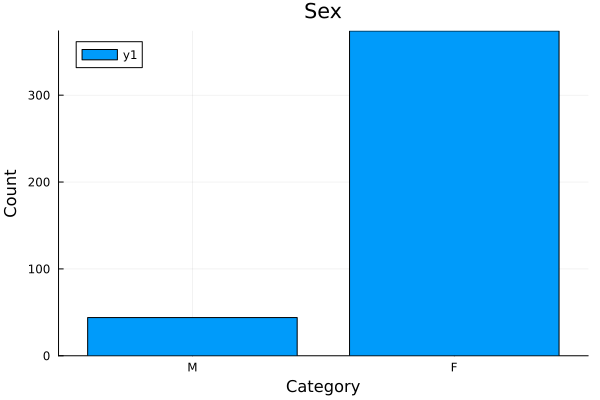

In [9]:
sexes = collect(keys(sex_counts))
counts = collect(values(sex_counts))

##plot
bar(sexes, counts, xlabel = "Category", ylabel = "Count", title = "Sex")

This observation is important, because our data is clearly skewed toward the Female category, which means our predictions learn more from F participants.

In [10]:
# encodes strings of Y/N/NA type that show the presence/absence of disease, or the unavailable data

disease_factors = ["Ascites", "Hepatomegaly", "Spiders", "Edema"]

for factor in disease_factors
    count = countmap(df[!, factor])
    println(factor, " :", count)
end

Ascites :Dict{String3, Int64}("Y" => 24, "N" => 288, "NA" => 106)
Hepatomegaly :Dict{String3, Int64}("Y" => 160, "N" => 152, "NA" => 106)
Spiders :Dict{String3, Int64}("Y" => 90, "N" => 222, "NA" => 106)
Edema :Dict{String1, Int64}("Y" => 20, "S" => 44, "N" => 354)


Observe:

- There is a high number of missing data for Ascites, Hepatomegaly and Spiders. We see that  NA = 106 for all three diseases. This is consistent with the information from the data dictionary, according to which 106 individuals did not take place in clinical trial, but undergone survival tracking. This individuals form a distinct group in that much data is missing from them.

- In "Edema", we have "N" for the absence of edema, "S" for edema without diuretics, or "Y" for edema 




There are two  important columns we should definitely examine:

- The group to which the patient belonged : Control(D-penicillamine), or Placebo ? We must also consider we have missing values representing the 106 untraceable patients.
- "Status", which is the variable that we must predict, our signal response. 

By performing regression, we are basically answering the question:

"If a patient suffering from liver-cirrosis, with such-and-such characteristics (encoded in the features), comes for treatment, what is the likelihood they will survive"?

This is the reason that we must carefully encode the categories of "Status", so the question can be answered.

In [11]:
count_status = countmap(df.Status)
println(count_status)

Dict{String3, Int64}("C" => 232, "D" => 161, "CL" => 25)


Observe:

- We have 161 deaths in the dataset, and $232+25 = 257$ people that survived. The classes Died/Survived will have some imbalance, more precisely : Dead/Survived : 161/257 

In [12]:
count_group = countmap(df.Drug)
println(count_group)

Dict{String15, Int64}("D-penicillamine" => 158, "Placebo" => 154, "NA" => 106)


Observe:

- Once again, 106 patients are not traceable, which is the source of missing data


*Some conclusions from looking at data*:

- Most missing data comes from patients that did not join the clinical trial
- Blood test values are strings, where they should have been numeric - we can do this conversion as part of data cleaning
- Also, we can one-hot encode the presence/absence of certain factors that are shown as Y/N strings
- Some features are skewed, for example the ratio of Females to Males
- In the same dataset, we have people that participated in the clinical trial and for which we have comprehensive data, and $NA = 106$ people who were tracked without participating in the clinical trial. 

<a class= 'anchor' id='section2'></a>
# 2. Clean the Data

We clearly have two different cohorts, and we can separate the clinical trial patients from the others. 

In [13]:
## filter the rows with missing value
df_trial = df[df.Drug .!= "NA", :]

312×20 DataFrame
 Row │ ID     N_Days  Status   Drug             Age    Sex      Ascites  Hepat ⋯
     │ Int64  Int64   String3  String15         Int64  String1  String3  Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1     400  D        D-penicillamine  21464  F        Y        Y     ⋯
   2 │     2    4500  C        D-penicillamine  20617  F        N        Y
   3 │     3    1012  D        D-penicillamine  25594  M        N        N
   4 │     4    1925  D        D-penicillamine  19994  F        N        Y
   5 │     5    1504  CL       Placebo          13918  F        N        Y     ⋯
   6 │     6    2503  D        Placebo          24201  F        N        Y
   7 │     7    1832  C        Placebo          20284  F        N        Y
   8 │     8    2466  D        Placebo          19379  F        N        N
   9 │     9    2400  D        D-penicillamine  15526  F        N        N     ⋯
  10 │    10      51  D        Placebo          25772  F        Y        N
  11 │    11    3762  D        Placebo          19619  F        N        Y
  ⋮  │   ⋮      ⋮        ⋮            ⋮           ⋮       ⋮        ⋮           ⋱
 303 │   303    1250  C        Placebo          22156  F        N        Y
 304 │   304    1230  C        D-penicillamine  12979  F        N        N     ⋯
 305 │   305    1216  C        Placebo          15730  F        N        Y
 306 │   306    1216  C        Placebo          20597  F        N        Y
 307 │   307    1149  C        Placebo          11167  F        N        N
 308 │   308    1153  C        D-penicillamine  22347  F        N        Y     ⋯
 309 │   309     994  C        Placebo          21294  F        N        N
 310 │   310     939  C        D-penicillamine  22767  F        N        N
 311 │   311     839  C        D-penicillamine  13879  F        N        N
 312 │   312     788  C        Placebo          12109  F        N        N     ⋯
                                                 13 columns and 291 rows omitted

Observe:

- We have exactly 312 cases of "complete" cases, exactly as per description 

## Convert to numeric

The first step is to record blood test measurements from "String" data to numeric data(float64). 

In [14]:
## custom function to parse potential "NA" values
safely_parse(x) = tryparse(Float64, x) == nothing ? missing : tryparse(Float64, x)

safely_parse (generic function with 1 method)

In [15]:
# list of blood tests that should be converted

blood_tests = ["Cholesterol",  "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

# convert the blood tests to numeric values
for test in blood_tests
    df_trial[!, test] = [safely_parse(value) for value in df_trial[!, test]]
end

In [16]:
describe(df_trial)

20×7 DataFrame
 Row │ variable       mean     min              median   max      nmissing  el ⋯
     │ Symbol         Union…   Any              Union…   Any      Int64     Ty ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID             156.5    1                156.5    312             0  In ⋯
   2 │ N_Days         2006.36  41               1839.5   4556            0  In
   3 │ Status                  C                         D               0  St
   4 │ Drug                    D-penicillamine           Placebo         0  St
   5 │ Age            18269.4  9598             18187.5  28650           0  In ⋯
   6 │ Sex                     F                         M               0  St
   7 │ Ascites                 N                         Y               0  St
   8 │ Hepatomegaly            N                         Y               0  St
   9 │ Spiders                 N                         Y               0  St ⋯
  10 │ Edema                   N                         Y               0  St
  11 │ Bilirubin      3.25609  0.3              1.35     28.0            0  Fl
  12 │ Cholesterol    369.511  120.0            309.5    1775.0         28  Un
  13 │ Albumin        3.52     1.96             3.55     4.64            0  Fl ⋯
  14 │ Copper         97.6484  4.0              73.0     588.0           2  Un
  15 │ Alk_Phos       1982.66  289.0            1259.0   13862.4         0  Fl
  16 │ SGOT           122.556  26.35            114.7    457.25          0  Fl
  17 │ Tryglicerides  124.702  33.0             108.0    598.0          30  Un ⋯
  18 │ Platelets      261.935  62.0             257.0    563.0           4  Un
  19 │ Prothrombin    10.7256  9.0              10.6     17.1            0  Fl
  20 │ Stage                   1                         4               0  St
                                                                1 column omitted

Observe:

- The conversion from string to numeric went as intended. There are missing values: 28 for cholesterol, 2 for copper, 30 for Tryglicerides and 4 for Platelets

Let's look at the rows with missing values

In [17]:
rows_mising = filter(row -> any(ismissing, row), df_trial)

36×20 DataFrame
 Row │ ID     N_Days  Status   Drug             Age    Sex      Ascites  Hepat ⋯
     │ Int64  Int64   String3  String15         Int64  String1  String3  Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     6    2503  D        Placebo          24201  F        N        Y     ⋯
   2 │    14    1217  D        Placebo          20535  M        Y        Y
   3 │    40    4467  C        D-penicillamine  17046  F        N        N
   4 │    41    1350  D        D-penicillamine  12285  F        N        Y
   5 │    42    4453  C        Placebo          12307  F        N        Y     ⋯
   6 │    45    4025  C        Placebo          15265  F        N        N
   7 │    49     708  D        Placebo          22336  F        N        Y
   8 │    53    1000  D        D-penicillamine  24621  F        N        Y
   9 │    58    4459  C        D-penicillamine  16279  M        N        N     ⋯
  10 │    70    3458  C        D-penicillamine  20600  F        N        N
  11 │    95     130  D        Placebo          16944  F        Y        Y
  ⋮  │   ⋮      ⋮        ⋮            ⋮           ⋮       ⋮        ⋮           ⋱
  27 │   190    2504  C        D-penicillamine  19916  F        N        N
  28 │   205    2081  D        D-penicillamine  17889  F        Y        N     ⋯
  29 │   207    2171  C        D-penicillamine  26580  F        N        N
  30 │   211    2195  C        Placebo          19327  F        N        N
  31 │   216    2168  C        D-penicillamine  21610  F        N        N
  32 │   218    2170  C        D-penicillamine  12636  F        N        N     ⋯
  33 │   238    1874  C        Placebo          24257  F        N        N
  34 │   261    1677  C        Placebo          19126  F        N        Y
  35 │   274    1447  CL       D-penicillamine  17525  F        N        N
  36 │   300     207  D        Placebo          21247  F        N        Y     ⋯
                                                  13 columns and 15 rows omitted

In [18]:
describe(rows_mising)

20×7 DataFrame
 Row │ variable       mean     min              median   max      nmissing  el ⋯
     │ Symbol         Union…   Any              Union…   Any      Int64     Ty ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID             140.278  6                148.0    300             0  In ⋯
   2 │ N_Days         2214.86  130              2183.0   4467            0  In
   3 │ Status                  C                         D               0  St
   4 │ Drug                    D-penicillamine           Placebo         0  St
   5 │ Age            18883.7  12285            19181.5  26580           0  In ⋯
   6 │ Sex                     F                         M               0  St
   7 │ Ascites                 N                         Y               0  St
   8 │ Hepatomegaly            N                         Y               0  St
   9 │ Spiders                 N                         Y               0  St ⋯
  10 │ Edema                   N                         Y               0  St
  11 │ Bilirubin      2.66111  0.4              1.1      17.4            0  Fl
  12 │ Cholesterol    309.125  242.0            274.5    420.0          28  Un
  13 │ Albumin        3.54444  2.23             3.655    4.64            0  Fl ⋯
  14 │ Copper         72.3235  14.0             54.0     234.0           2  Un
  15 │ Alk_Phos       1875.66  559.0            1090.0   11046.6         0  Fl
  16 │ SGOT           110.574  26.35            98.425   299.15          0  Fl
  17 │ Tryglicerides  112.0    63.0             95.5     232.0          30  Un ⋯
  18 │ Platelets      263.344  88.0             249.0    539.0           4  Un
  19 │ Prothrombin    10.65    9.2              10.4     13.3            0  Fl
  20 │ Stage                   1                         4               0  St
                                                                1 column omitted

Observe:

- Ideally, I would consult the people collecting these data, to understand if the *missing* data is due to imputation error, or collection error for these patients
- There doesn't seem to be any clear pattern for these patients
- since data is missing mostly for two columns, dropping all the rows with missing data will result in data loss


I will do mean imputation for these missing data, as this will likely not affect the underlying distributions much, and it will allow me to use the rest of the data.

In [19]:
for col in blood_tests

    # calculate mean
    col_mean = mean(skipmissing(df_trial[!, col])) ##calculate the mean of the column, skipping missing values

    # impute
    df_trial[!, col] = coalesce.(df_trial[!, col], col_mean)  

end 

In [20]:
describe(df_trial)  

20×7 DataFrame
 Row │ variable       mean     min              median   max      nmissing  el ⋯
     │ Symbol         Union…   Any              Union…   Any      Int64     Da ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID             156.5    1                156.5    312             0  In ⋯
   2 │ N_Days         2006.36  41               1839.5   4556            0  In
   3 │ Status                  C                         D               0  St
   4 │ Drug                    D-penicillamine           Placebo         0  St
   5 │ Age            18269.4  9598             18187.5  28650           0  In ⋯
   6 │ Sex                     F                         M               0  St
   7 │ Ascites                 N                         Y               0  St
   8 │ Hepatomegaly            N                         Y               0  St
   9 │ Spiders                 N                         Y               0  St ⋯
  10 │ Edema                   N                         Y               0  St
  11 │ Bilirubin      3.25609  0.3              1.35     28.0            0  Fl
  12 │ Cholesterol    369.511  120.0            322.0    1775.0          0  Fl
  13 │ Albumin        3.52     1.96             3.55     4.64            0  Fl ⋯
  14 │ Copper         97.6484  4.0              73.0     588.0           0  Fl
  15 │ Alk_Phos       1982.66  289.0            1259.0   13862.4         0  Fl
  16 │ SGOT           122.556  26.35            114.7    457.25          0  Fl
  17 │ Tryglicerides  124.702  33.0             114.0    598.0           0  Fl ⋯
  18 │ Platelets      261.935  62.0             258.5    563.0           0  Fl
  19 │ Prothrombin    10.7256  9.0              10.6     17.1            0  Fl
  20 │ Stage                   1                         4               0  St
                                                                1 column omitted

## One-hot encoding

The next step, is to one-hot encode the presence of certain factors : "Ascites", "Hepatomegaly", "Spiders", "Edema". But to deal with one-hot encoding, I will write a function that performs these operations.

In [21]:
## features that represent absence/presence of conditions

disease_factors = ["Ascites", "Hepatomegaly", "Spiders", "Edema"]

4-element Vector{String}:
 "Ascites"
 "Hepatomegaly"
 "Spiders"
 "Edema"

In [22]:
## create function to one-hot encode the data
function one_hot_encode(df::DataFrame, cols::Vector{String})
    """ Function that takes dataframe, one-hot encodes selected columns, and returns the transformed dataframe
    df : dataframe to be transformed
    cols : columns to be one-hot encoded
    """

    for col in cols

        df[!, col] = categorical(df[!, col]) #convert to categorical

        # get unique categories and skip missing values
        cats = unique(skipmissing(df[!, col]))

        # for each unique category, create one-hot new column
        for cat in cats
            df[!, Symbol(string(col, "_", cat))] = ifelse.(df[!, col] .== cat, 1, 0) 
        end

        # drop the original column
        select!(df, Not(col))

    end

    return df 
end



one_hot_encode (generic function with 1 method)

In [23]:
df_encoded = one_hot_encode(df_trial, disease_factors)

312×25 DataFrame
 Row │ ID     N_Days  Status   Drug             Age    Sex      Bilirubin  Cho ⋯
     │ Int64  Int64   String3  String15         Int64  String1  Float64    Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1     400  D        D-penicillamine  21464  F             14.5      ⋯
   2 │     2    4500  C        D-penicillamine  20617  F              1.1
   3 │     3    1012  D        D-penicillamine  25594  M              1.4
   4 │     4    1925  D        D-penicillamine  19994  F              1.8
   5 │     5    1504  CL       Placebo          13918  F              3.4      ⋯
   6 │     6    2503  D        Placebo          24201  F              0.8
   7 │     7    1832  C        Placebo          20284  F              1.0
   8 │     8    2466  D        Placebo          19379  F              0.3
   9 │     9    2400  D        D-penicillamine  15526  F              3.2      ⋯
  10 │    10      51  D        Placebo          25772  F             12.6
  11 │    11    3762  D        Placebo          19619  F              1.4
  ⋮  │   ⋮      ⋮        ⋮            ⋮           ⋮       ⋮         ⋮          ⋱
 303 │   303    1250  C        Placebo          22156  F              1.0
 304 │   304    1230  C        D-penicillamine  12979  F              0.5      ⋯
 305 │   305    1216  C        Placebo          15730  F              2.9
 306 │   306    1216  C        Placebo          20597  F              0.6
 307 │   307    1149  C        Placebo          11167  F              0.8
 308 │   308    1153  C        D-penicillamine  22347  F              0.4      ⋯
 309 │   309     994  C        Placebo          21294  F              0.4
 310 │   310     939  C        D-penicillamine  22767  F              1.7
 311 │   311     839  C        D-penicillamine  13879  F              2.0
 312 │   312     788  C        Placebo          12109  F              6.4      ⋯
                                                 18 columns and 291 rows omitted

Observe:

- The "One_hot_encode" function took the columns given, and create one-hot column based on the underlying categories
- We had 4 columns that we one-hot encoded, 3 of them with two responses (Y/N) and "Edema" with 3 responses (Y/N/S). This means a total of 9 new columns, which is exactly what the function did

We can now re-use this function for the remaining categories that we wish to one-hot encode : "Drug, Stage and Status

In [24]:
remaining_cols = ["Drug", "Status", "Stage", "Sex"] # columns that are not one-hot encoded, and should be

# encode the remaining columns via function
df_encoded = one_hot_encode(df_encoded, remaining_cols)

312×32 DataFrame
 Row │ ID     N_Days  Age    Bilirubin  Cholesterol  Albumin  Copper   Alk_Pho ⋯
     │ Int64  Int64   Int64  Float64    Float64      Float64  Float64  Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1     400  21464       14.5      261.0       2.6     156.0    1718. ⋯
   2 │     2    4500  20617        1.1      302.0       4.14     54.0    7394.
   3 │     3    1012  25594        1.4      176.0       3.48    210.0     516.
   4 │     4    1925  19994        1.8      244.0       2.54     64.0    6121.
   5 │     5    1504  13918        3.4      279.0       3.53    143.0     671. ⋯
   6 │     6    2503  24201        0.8      248.0       3.98     50.0     944.
   7 │     7    1832  20284        1.0      322.0       4.09     52.0     824.
   8 │     8    2466  19379        0.3      280.0       4.0      52.0    4651.
   9 │     9    2400  15526        3.2      562.0       3.08     79.0    2276. ⋯
  10 │    10      51  25772       12.6      200.0       2.74    140.0     918.
  11 │    11    3762  19619        1.4      259.0       4.16     46.0    1104.
  ⋮  │   ⋮      ⋮       ⋮        ⋮           ⋮          ⋮        ⋮        ⋮    ⋱
 303 │   303    1250  22156        1.0      372.0       3.25    108.0    1190.
 304 │   304    1230  12979        0.5      219.0       3.93     22.0     663. ⋯
 305 │   305    1216  15730        2.9      426.0       3.61     73.0    5184.
 306 │   306    1216  20597        0.6      239.0       3.45     31.0    1072.
 307 │   307    1149  11167        0.8      273.0       3.56     52.0    1282.
 308 │   308    1153  22347        0.4      246.0       3.58     24.0     797. ⋯
 309 │   309     994  21294        0.4      260.0       2.75     41.0    1166.
 310 │   310     939  22767        1.7      434.0       3.35     39.0    1713.
 311 │   311     839  13879        2.0      247.0       3.16     69.0    1050.
 312 │   312     788  12109        6.4      576.0       3.79    186.0    2115. ⋯
                                                 25 columns and 291 rows omitted

Now, for our purposes, we are only interested in whether the patient died or not. This information is actually encoded in Status_D : if Status_D is 1, patient died, if Status_D is 0 patient belongs to either Status_C or Status_CL, so they did not die. Also, the ID column provides no useful information for classification. This means we can drop three columns:

- ID
- Status_C
- Status_CL

In [25]:
df_prep = select!(df_encoded, Not([:ID, :Status_C, :Status_CL])) # drop the columns that do not provide useful information

312×29 DataFrame
 Row │ N_Days  Age    Bilirubin  Cholesterol  Albumin  Copper   Alk_Phos  SGOT ⋯
     │ Int64   Int64  Float64    Float64      Float64  Float64  Float64   Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    400  21464       14.5      261.0       2.6     156.0    1718.0   137 ⋯
   2 │   4500  20617        1.1      302.0       4.14     54.0    7394.8   113
   3 │   1012  25594        1.4      176.0       3.48    210.0     516.0    96
   4 │   1925  19994        1.8      244.0       2.54     64.0    6121.8    60
   5 │   1504  13918        3.4      279.0       3.53    143.0     671.0   113 ⋯
   6 │   2503  24201        0.8      248.0       3.98     50.0     944.0    93
   7 │   1832  20284        1.0      322.0       4.09     52.0     824.0    60
   8 │   2466  19379        0.3      280.0       4.0      52.0    4651.2    28
   9 │   2400  15526        3.2      562.0       3.08     79.0    2276.0   144 ⋯
  10 │     51  25772       12.6      200.0       2.74    140.0     918.0   147
  11 │   3762  19619        1.4      259.0       4.16     46.0    1104.0    79
  ⋮  │   ⋮       ⋮        ⋮           ⋮          ⋮        ⋮        ⋮         ⋮ ⋱
 303 │   1250  22156        1.0      372.0       3.25    108.0    1190.0   140
 304 │   1230  12979        0.5      219.0       3.93     22.0     663.0    45 ⋯
 305 │   1216  15730        2.9      426.0       3.61     73.0    5184.0   288
 306 │   1216  20597        0.6      239.0       3.45     31.0    1072.0    55
 307 │   1149  11167        0.8      273.0       3.56     52.0    1282.0   130
 308 │   1153  22347        0.4      246.0       3.58     24.0     797.0    91 ⋯
 309 │    994  21294        0.4      260.0       2.75     41.0    1166.0    70
 310 │    939  22767        1.7      434.0       3.35     39.0    1713.0   171
 311 │    839  13879        2.0      247.0       3.16     69.0    1050.0   117
 312 │    788  12109        6.4      576.0       3.79    186.0    2115.0   136 ⋯
                                                 22 columns and 291 rows omitted

Now, let us rename our response column, to make sure it is easy to recognize. This is not a necessary step, but it does help in claryfing which column we are trying to predict, especially when looking at the data later in the workflow.

In [26]:
df_prep = rename!(df_prep, :Status_D => :Y) # rename the target column to Y as this is our response

312×29 DataFrame
 Row │ N_Days  Age    Bilirubin  Cholesterol  Albumin  Copper   Alk_Phos  SGOT ⋯
     │ Int64   Int64  Float64    Float64      Float64  Float64  Float64   Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    400  21464       14.5      261.0       2.6     156.0    1718.0   137 ⋯
   2 │   4500  20617        1.1      302.0       4.14     54.0    7394.8   113
   3 │   1012  25594        1.4      176.0       3.48    210.0     516.0    96
   4 │   1925  19994        1.8      244.0       2.54     64.0    6121.8    60
   5 │   1504  13918        3.4      279.0       3.53    143.0     671.0   113 ⋯
   6 │   2503  24201        0.8      248.0       3.98     50.0     944.0    93
   7 │   1832  20284        1.0      322.0       4.09     52.0     824.0    60
   8 │   2466  19379        0.3      280.0       4.0      52.0    4651.2    28
   9 │   2400  15526        3.2      562.0       3.08     79.0    2276.0   144 ⋯
  10 │     51  25772       12.6      200.0       2.74    140.0     918.0   147
  11 │   3762  19619        1.4      259.0       4.16     46.0    1104.0    79
  ⋮  │   ⋮       ⋮        ⋮           ⋮          ⋮        ⋮        ⋮         ⋮ ⋱
 303 │   1250  22156        1.0      372.0       3.25    108.0    1190.0   140
 304 │   1230  12979        0.5      219.0       3.93     22.0     663.0    45 ⋯
 305 │   1216  15730        2.9      426.0       3.61     73.0    5184.0   288
 306 │   1216  20597        0.6      239.0       3.45     31.0    1072.0    55
 307 │   1149  11167        0.8      273.0       3.56     52.0    1282.0   130
 308 │   1153  22347        0.4      246.0       3.58     24.0     797.0    91 ⋯
 309 │    994  21294        0.4      260.0       2.75     41.0    1166.0    70
 310 │    939  22767        1.7      434.0       3.35     39.0    1713.0   171
 311 │    839  13879        2.0      247.0       3.16     69.0    1050.0   117
 312 │    788  12109        6.4      576.0       3.79    186.0    2115.0   136 ⋯
                                                 22 columns and 291 rows omitted

We are almost done! We have our response, Y, which we are trying to predict from the rest of the features. Now, all we must do is create a training and test set . Once we get the test set, we do not want to look at it until we are testing our model (we pretend it is new data).

## Splitting the Data

The first thing to notice, is that we do not have much data. So, we would want to maximise the available training data, while ensuring enough test data. Let's go with 80-20 split, 80% of the data for the training set and 20% of the test set. But let us first understand if the classes that we are trying to predict (Y), are balanced, because this will influence our choice of metric.

[187, 125]
Percentage of survived: 59.93589743589743
Percentage of deaths: 40.06410256410257


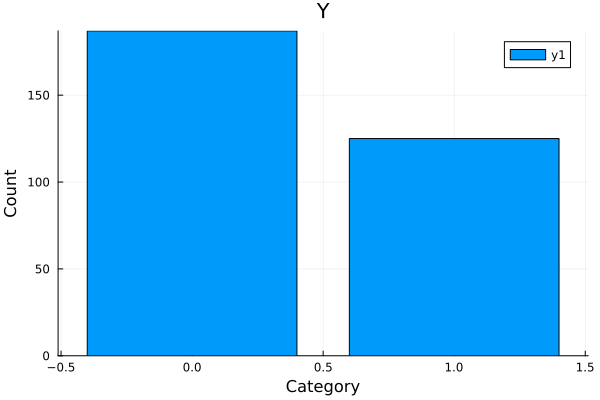

In [27]:
# look at balance of the classes in the response variable

# count classe
classes_Y = countmap(df_prep.Y)

cls= collect(keys(classes_Y))
cnt = collect(values(classes_Y))

#print the classes
println(cnt)

##print percetage of classes
println("Percentage of survived: ", cnt[1]/sum(cnt)*100)
println("Percentage of deaths: ", cnt[2]/sum(cnt)*100)

##plot
bar(cls, cnt, xlabel = "Category", ylabel = "Count", title = "Y")


Observe:

- The classes are imbalanced, but the imbalance seems to be mild. Roughly 60% of people survived, and the rest died

In [28]:
nrow(df_prep)

312

In [29]:
# Split the data into training and testing sets

function train_test_split(df::DataFrame, at::Float64)
    """ Function that takes a dataframe and a ratio at which to split the data into training and testing sets
    df : dataframe to be split
    at : ratio at which to split the data
    """

    n = nrow(df) # get the number of rows in the dataframe
    idxs = shuffle(1:n) # shuffle the indices of the rows

    train_size = Int(floor(n*at)) # calculate the size of the training set
    test_size = n - train_size # calculate the size of the testing set

    # return the data split into training and testing sets
    return df[idxs[1:train_size], :], df[idxs[train_size+1:end], :]
end

train_test_split (generic function with 1 method)

Now let us split the data accordingly

In [30]:
Random.seed!(123) # seed the random number generator
train, test = train_test_split(df_prep, 0.8)    # split the data into training and testing sets

(249×29 DataFrame
 Row │ N_Days  Age    Bilirubin  Cholesterol  Albumin  Copper   Alk_Phos  SGOT ⋯
     │ Int64   Int64  Float64    Float64      Float64  Float64  Float64   Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   1978  20708        0.5      223.0       3.7      39.0     884.0    75 ⋯
   2 │   4039  11912        0.7      174.0       4.09     58.0     642.0    71
   3 │   1682  22265        0.9      376.0       3.86    200.0    1015.0    83
   4 │   1012  25594        1.4      176.0       3.48    210.0     516.0    96
   5 │   3336  22306        3.0      458.0       3.63     74.0    1588.0   106 ⋯
   6 │   2443  19256        0.9      308.0       3.69     67.0     696.0    51
   7 │   2466  19379        0.3      280.0       4.0      52.0    4651.2    28
   8 │   4079  16261        2.1      456.0       4.0     124.0    5719.0   221
   9 │   3239  23235        0.9      420.0       3.87     30.0    1009.0    57 ⋯
  10 │   1614  20567  

In [31]:
nrow(train), nrow(test)  # print the number of rows in the training and testing sets

(249, 63)

Observe:

- We have 249 training instances, and 63 test instances

<a class= 'anchor' id='section3'></a>
# 3. EDA 

In this section, I will explore the data to identify interesting patterns or correlations

In [32]:
# create copy of training Set
train_copy = copy(train)

249×29 DataFrame
 Row │ N_Days  Age    Bilirubin  Cholesterol  Albumin  Copper   Alk_Phos  SGOT ⋯
     │ Int64   Int64  Float64    Float64      Float64  Float64  Float64   Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   1978  20708        0.5      223.0       3.7      39.0     884.0    75 ⋯
   2 │   4039  11912        0.7      174.0       4.09     58.0     642.0    71
   3 │   1682  22265        0.9      376.0       3.86    200.0    1015.0    83
   4 │   1012  25594        1.4      176.0       3.48    210.0     516.0    96
   5 │   3336  22306        3.0      458.0       3.63     74.0    1588.0   106 ⋯
   6 │   2443  19256        0.9      308.0       3.69     67.0     696.0    51
   7 │   2466  19379        0.3      280.0       4.0      52.0    4651.2    28
   8 │   4079  16261        2.1      456.0       4.0     124.0    5719.0   221
   9 │   3239  23235        0.9      420.0       3.87     30.0    1009.0    57 ⋯
  10 │   1614  20567        0.5      318.0       3.32     52.0     613.0    70
  11 │   3445  23445        0.6      252.0       3.83     41.0     843.0    65
  ⋮  │   ⋮       ⋮        ⋮           ⋮          ⋮        ⋮        ⋮         ⋮ ⋱
 240 │   1153  22347        0.4      246.0       3.58     24.0     797.0    91
 241 │   1217  20535        0.8      369.511     2.27     43.0     728.0    71 ⋯
 242 │   1810  23585        1.9      354.0       2.97     86.0    1553.0   196
 243 │   1363  24101        1.4      294.0       3.57     33.0     722.0    93
 244 │   3282  19567        2.3      260.0       3.18    231.0   11320.2   105
 245 │     41  24064       17.9      175.0       2.1     220.0     705.0   338 ⋯
 246 │   1525  14025        0.5      226.0       2.93     22.0     674.0    58
 247 │   2713  17442        0.4      257.0       3.8      44.0     842.0    97
 248 │   1832  20284        1.0      322.0       4.09     52.0     824.0    60
 249 │   1433  20510        0.5      198.0       3.77     38.0     911.0    57 ⋯
                                                 22 columns and 228 rows omitted

In [33]:
# visualize histograms of the features
function hists_num(df::DataFrame)
    """Function that plots histograms of all numerical features in a dataframe
    df: dataframe to be visualized
    """

    # extract numeric columns

    numeric_columns = [name for name in names(df) if eltype(df[!, name]) <: Number]

    n = length(numeric_columns)
    n_rows = round(Int, sqrt(n))
    n_cols = n_rows + n%2
    plots = []

    for col in numeric_columns # iterate through columns
        p = histogram(df[!, col], title = col, legend = false) # create histogram
        push!(plots, p)

    end

    plot(plots..., layout = (n_rows, n_cols), size = (600*n_rows, 200*n_cols)) # plot all histograms

end
        
    

hists_num (generic function with 1 method)

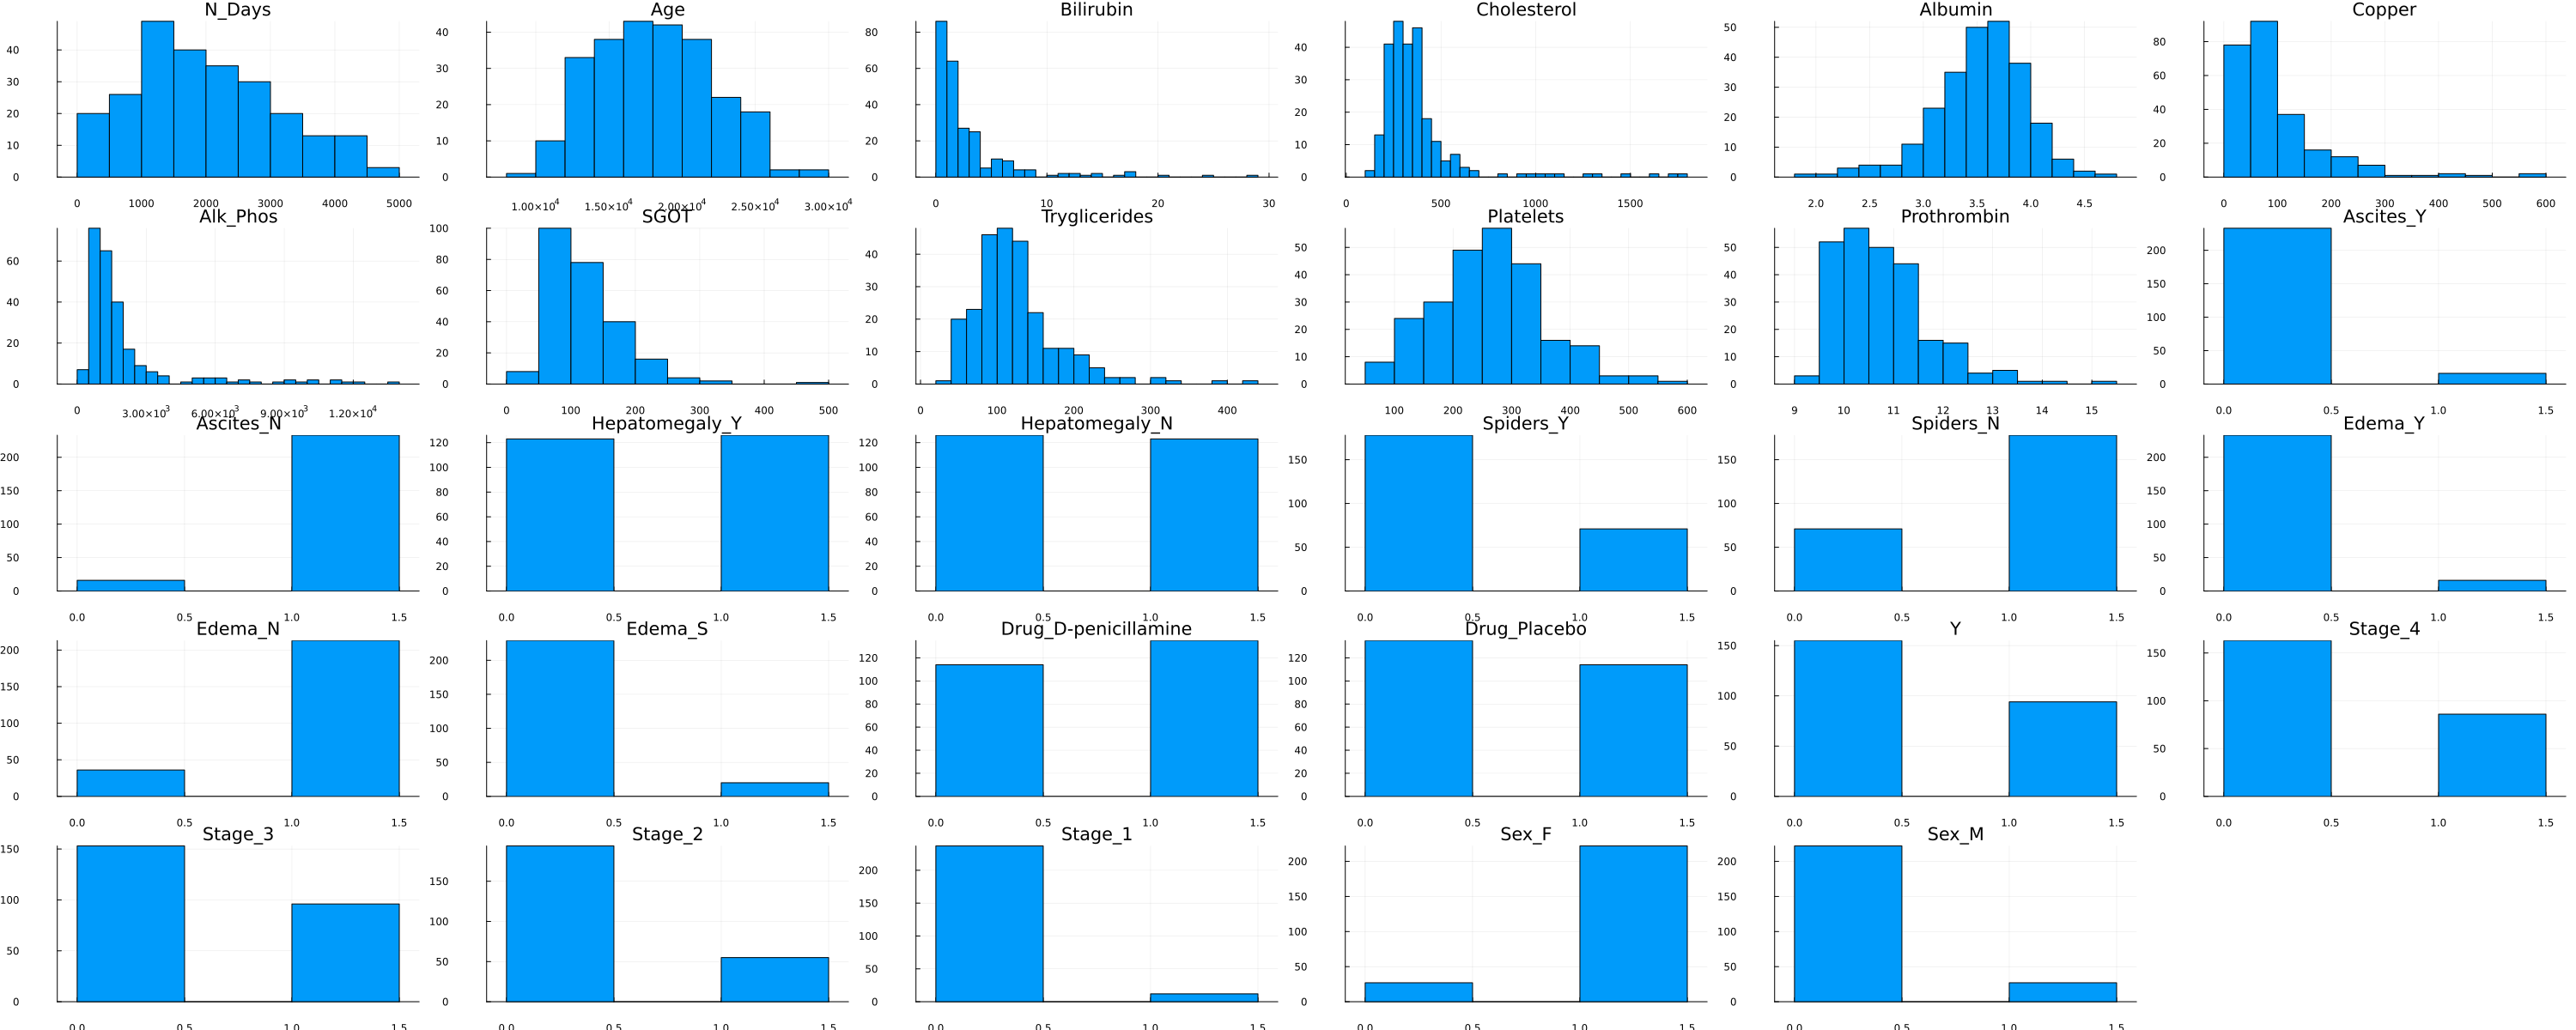

In [34]:
hists_num(train_copy)

Observe:

- Some features are clearly right-skewed : Bilirubin, Cholesterol, Alk_phos, SGOT, Tryglicerides, Prothombim
- It would make sense to transform them, for example by applying a logarithm, as drawing from normal distributions is better than drawing from skewed distributions

Before deciding on any transformations, I will also look at correlations. This is because drawing from closely correlated features will likely hurt the model.

In [35]:
println(names(train_copy)) 

["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin", "Ascites_Y", "Ascites_N", "Hepatomegaly_Y", "Hepatomegaly_N", "Spiders_Y", "Spiders_N", "Edema_Y", "Edema_N", "Edema_S", "Drug_D-penicillamine", "Drug_Placebo", "Y", "Stage_4", "Stage_3", "Stage_2", "Stage_1", "Sex_F", "Sex_M"]


In [36]:
# select continuous features
cont_feats = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

11-element Vector{String}:
 "N_Days"
 "Age"
 "Bilirubin"
 "Cholesterol"
 "Albumin"
 "Copper"
 "Alk_Phos"
 "SGOT"
 "Tryglicerides"
 "Platelets"
 "Prothrombin"

In [37]:
train_cont = train_copy[!, cont_feats] # select the continuous features  

249×11 DataFrame
 Row │ N_Days  Age    Bilirubin  Cholesterol  Albumin  Copper   Alk_Phos  SGOT ⋯
     │ Int64   Int64  Float64    Float64      Float64  Float64  Float64   Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   1978  20708        0.5      223.0       3.7      39.0     884.0    75 ⋯
   2 │   4039  11912        0.7      174.0       4.09     58.0     642.0    71
   3 │   1682  22265        0.9      376.0       3.86    200.0    1015.0    83
   4 │   1012  25594        1.4      176.0       3.48    210.0     516.0    96
   5 │   3336  22306        3.0      458.0       3.63     74.0    1588.0   106 ⋯
   6 │   2443  19256        0.9      308.0       3.69     67.0     696.0    51
   7 │   2466  19379        0.3      280.0       4.0      52.0    4651.2    28
   8 │   4079  16261        2.1      456.0       4.0     124.0    5719.0   221
   9 │   3239  23235        0.9      420.0       3.87     30.0    1009.0    57 ⋯
  10 │   1614  20567        0.5      318.0       3.32     52.0     613.0    70
  11 │   3445  23445        0.6      252.0       3.83     41.0     843.0    65
  ⋮  │   ⋮       ⋮        ⋮           ⋮          ⋮        ⋮        ⋮         ⋮ ⋱
 240 │   1153  22347        0.4      246.0       3.58     24.0     797.0    91
 241 │   1217  20535        0.8      369.511     2.27     43.0     728.0    71 ⋯
 242 │   1810  23585        1.9      354.0       2.97     86.0    1553.0   196
 243 │   1363  24101        1.4      294.0       3.57     33.0     722.0    93
 244 │   3282  19567        2.3      260.0       3.18    231.0   11320.2   105
 245 │     41  24064       17.9      175.0       2.1     220.0     705.0   338 ⋯
 246 │   1525  14025        0.5      226.0       2.93     22.0     674.0    58
 247 │   2713  17442        0.4      257.0       3.8      44.0     842.0    97
 248 │   1832  20284        1.0      322.0       4.09     52.0     824.0    60
 249 │   1433  20510        0.5      198.0       3.77     38.0     911.0    57 ⋯
                                                  4 columns and 228 rows omitted

In [38]:
train_cat = train_copy[:, Not(cont_feats)] # select the categorical features

249×18 DataFrame
 Row │ Ascites_Y  Ascites_N  Hepatomegaly_Y  Hepatomegaly_N  Spiders_Y  Spider ⋯
     │ Int64      Int64      Int64           Int64           Int64      Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │         0          1               1               0          0         ⋯
   2 │         0          1               0               1          0
   3 │         0          1               1               0          0
   4 │         0          1               0               1          0
   5 │         0          1               0               1          1         ⋯
   6 │         0          1               1               0          0
   7 │         0          1               0               1          0
   8 │         0          1               1               0          0
   9 │         0          1               1               0          0         ⋯
  10 │         0          1               0               1          0
  11 │         0          1               1               0          1
  ⋮  │     ⋮          ⋮            ⋮               ⋮             ⋮          ⋮  ⋱
 240 │         0          1               1               0          0
 241 │         1          0               1               0          0         ⋯
 242 │         0          1               1               0          0
 243 │         0          1               0               1          0
 244 │         0          1               1               0          0
 245 │         1          0               0               1          0         ⋯
 246 │         0          1               0               1          0
 247 │         0          1               1               0          0
 248 │         0          1               1               0          0
 249 │         0          1               0               1          0         ⋯
                                                 13 columns and 228 rows omitted

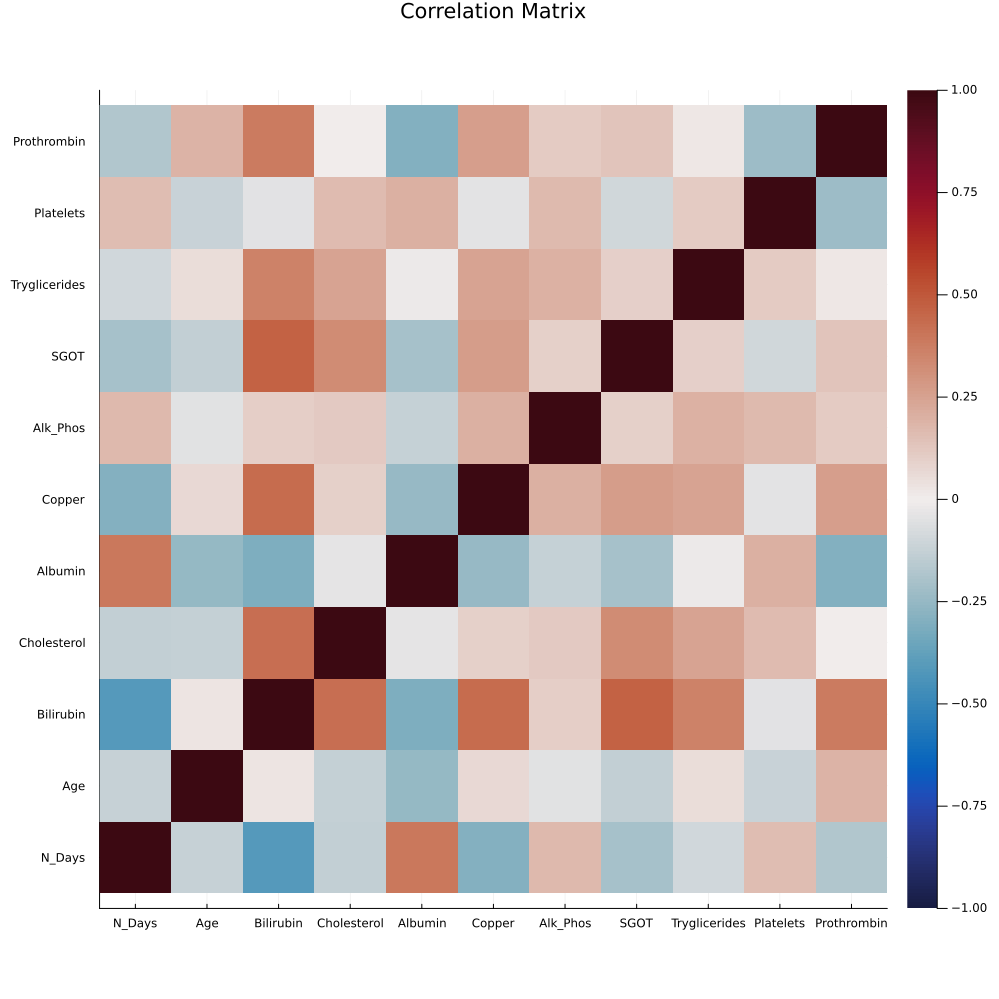

In [39]:
# create correlation matrix
cor_mat = cor(Matrix(train_cont))

# Visualise correlation heatmap
p = heatmap(names(train_cont), names(train_cont), cor_mat, aspect_ratio = 1, color = :balance, title = "Correlation Matrix", clim = (-1, 1), size = (1000, 1000))


# Display the plot
display(p)

Observe:

- Bilurubin and copper are positively correlated
- The number of days and bilirubin are negatively correlated
- Most other correlations seem mild

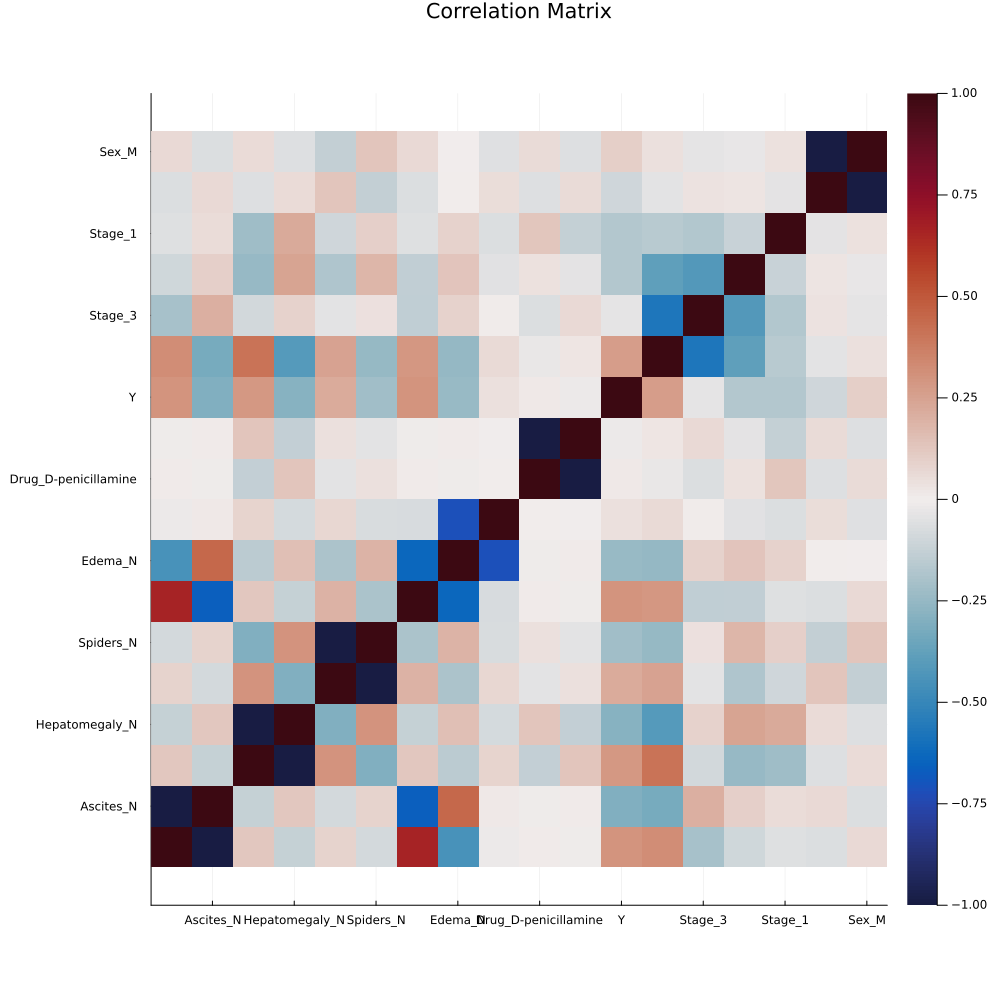

In [40]:
cor_mat_cat = cor(Matrix(train_cat))

p = heatmap(names(train_cat), names(train_cat), cor_mat_cat, aspect_ratio = 1, color = :balance, title = "Correlation Matrix", clim = (-1, 1), size = (1000, 1000))

display(p)

- Ascites_N and Edema_N seems to be well correlated
- Normally, it would be worth consulting with the clinicians, to understand if such a correlation would be expected or if it is a feature of this dataset

<a class= 'anchor' id='section4'></a>
# 4. Experiment with Transformations

Let's experiement with some transformations, for example on skewed columns, to understand how we can make the distributions more symmetric. Below there is a function that :

- Transforms the column by adding a constant and taking the logarithm
- Transforms the column by adding a constant and taking the square root

In [41]:
function trans_vis(df::DataFrame, col::String, constant1::Float64, constant2::Float64)
    """ Function that takes a dataframe and a column name, and returns a plot of the column and its log-transformed values
    df : dataframe to be visualized
    col : column to be transformed
    """

    p1 = histogram(df[!, col], title = col, bins =50, legend = false) # create histogram of the column
    p2 = histogram(log.(df[!, col] .+ constant1), bins = 50,  title = string("log(", col, ")"), legend = false) # create histogram of the log-transformed column
    p3 = histogram(sqrt.(df[!, col] .+ constant2), bins = 50,  title = string("sqrt(", col, ")"), legend = false) # create histogram of the log-transformed column

    plot(p1, p2, p3, layout = (1, 3), size = (1000, 500)) # plot both histograms side by side

end

trans_vis (generic function with 1 method)

## Bilirubin

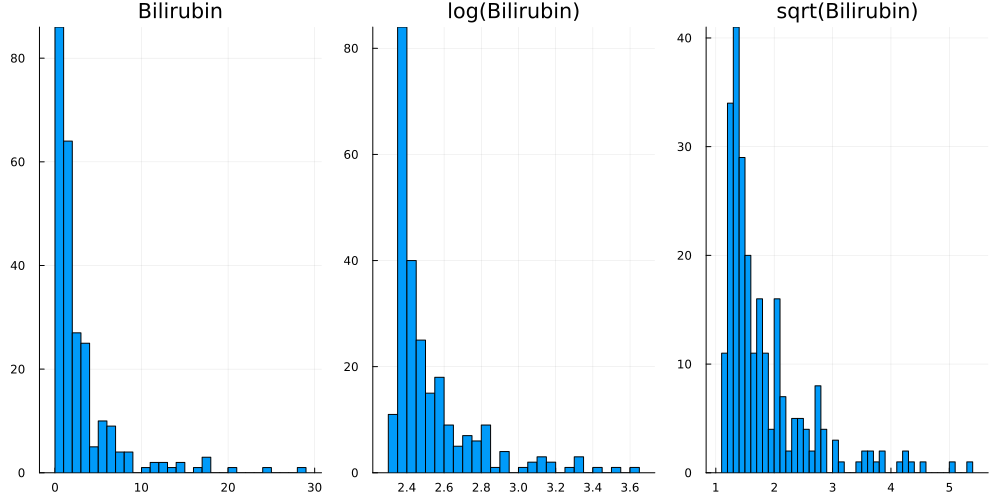

In [42]:
trans_vis(train_cont, "Bilirubin", 10.0, 1.0)

Observe:

- Taking the logarithm improves the distribution, as it is now more symmetric

## Cholesterol

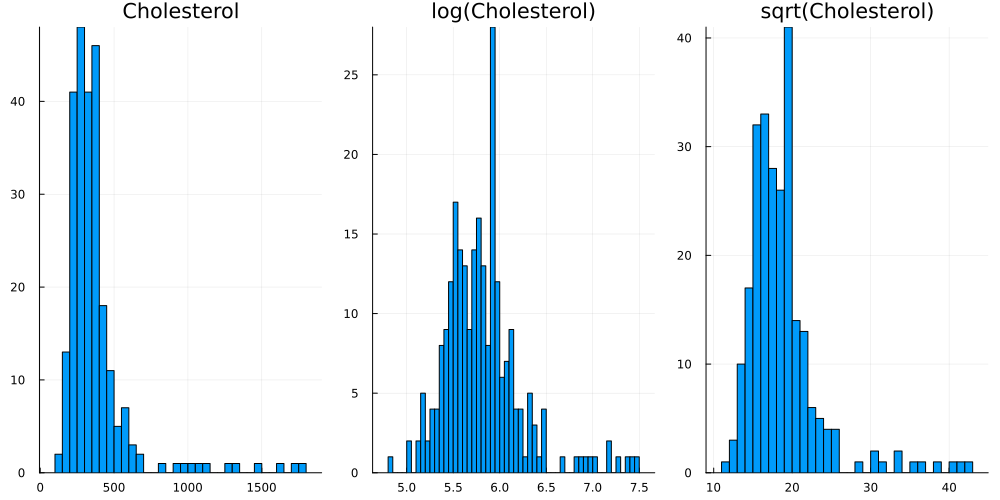

In [43]:
trans_vis(train_cont, "Cholesterol", 0.0, 0.0)  

- The improvement is quite clear, especially with logarithm 

## Copper

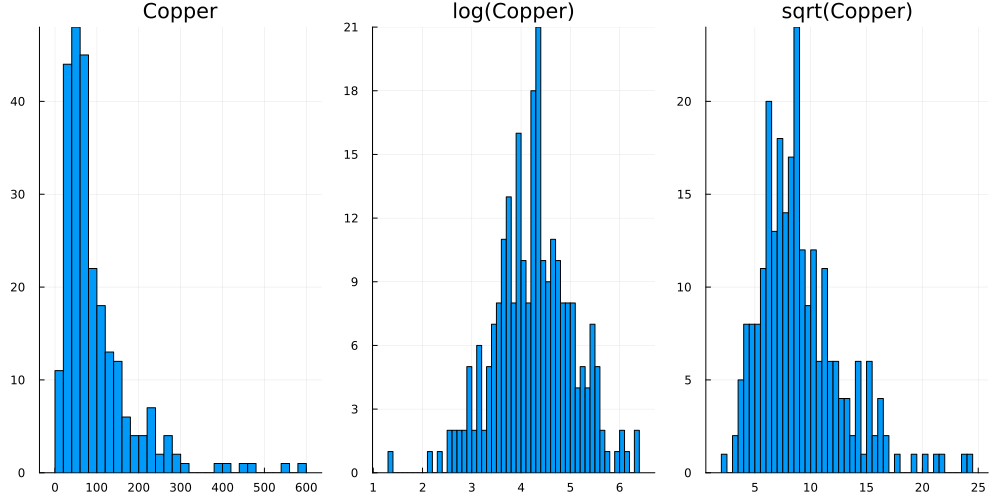

In [44]:
trans_vis(train_cont, "Copper", 0.0, 0.0)

- Definitely less skewed when taking the logarithm

## Alk_Phos

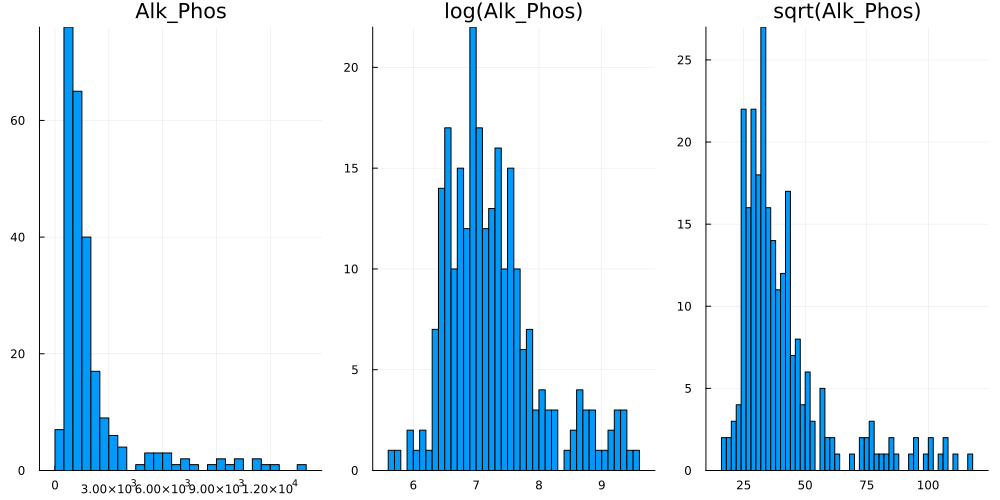

In [45]:
trans_vis(train_cont, "Alk_Phos", 0.0,  0.0)

## SGOT

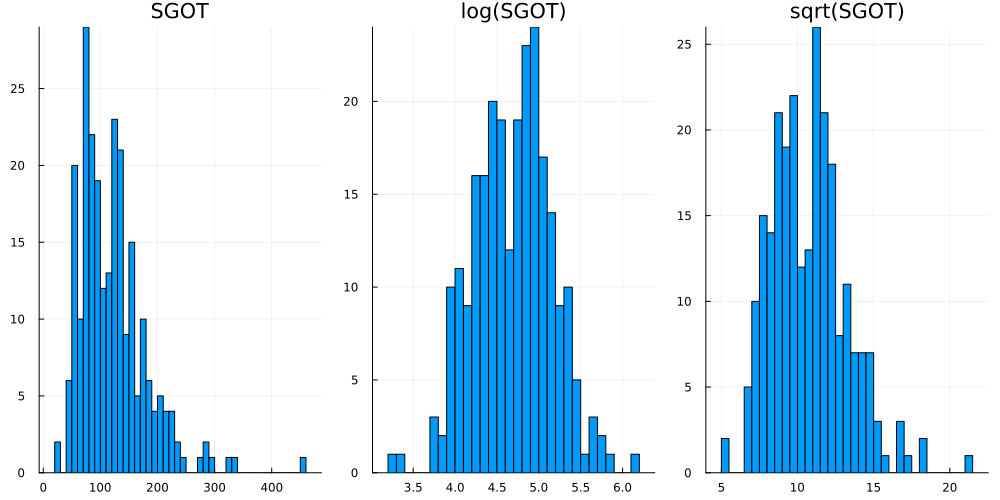

In [46]:
trans_vis(train_cont, "SGOT", 0.0, 0.5)

## Tryglicerides

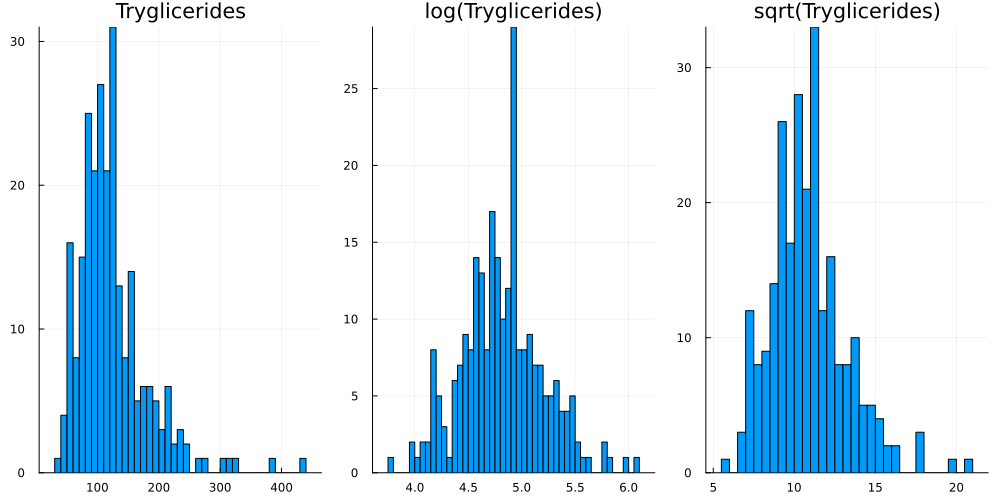

In [47]:
trans_vis(train_cont, "Tryglicerides", 10.0, 0.0)

Note:

- For tryglicerides, taking the log is better than taking the square root

## Phrothrombin

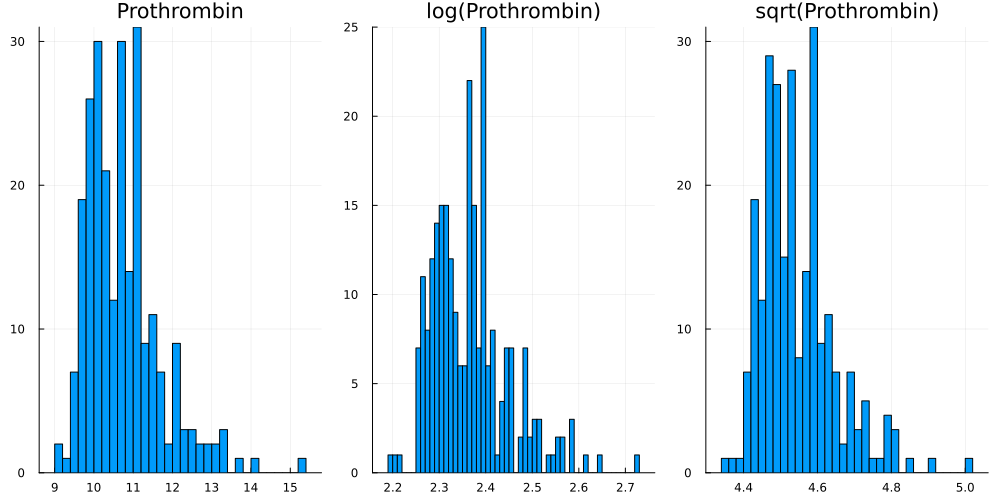

In [48]:
trans_vis(train_cont, "Prothrombin", 0.0, 10.0)

In this case, the skewness is not reduced by much, we could try taking the sqaure instead.

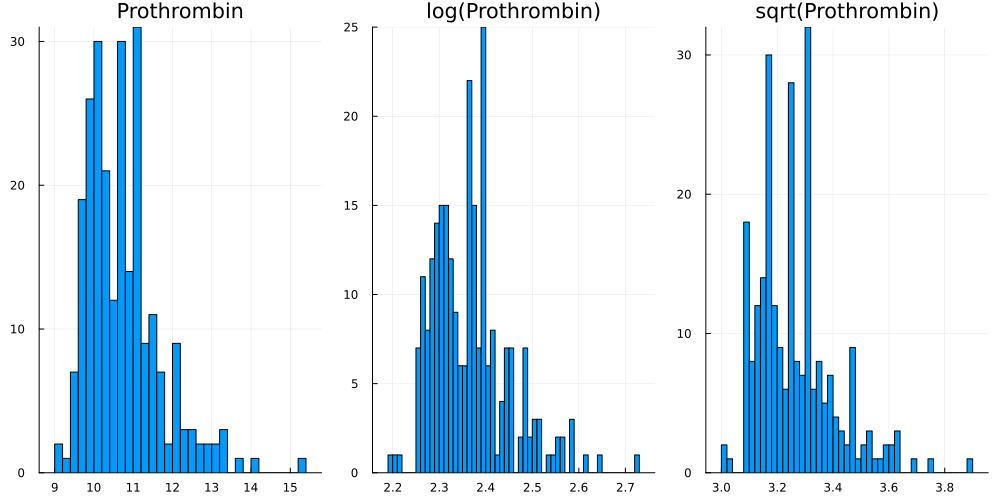

In [49]:
trans_vis(train_cont, "Prothrombin", 0.0, 0.0)

Note:

- Generally, taking the logarithm of skewed distribution seems to reduce skewness, making the distributions more symmetric. Based on this, it seems like a good idea to built a transformation pipeline that will take the skewed columns and transform them by taking the logarithm. Clearly, this pipeline will apply to make the training and test data. Also, it seems a good idea to standardize the data, so this should be included in the pipeline.

## Build Simple Pipeline

In [50]:
# columns to standardize

cont_feats = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

# columns to log-transform

skew_feats = ["Bilirubin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Prothrombin", "Cholesterol"]

7-element Vector{String}:
 "Bilirubin"
 "Copper"
 "Alk_Phos"
 "SGOT"
 "Tryglicerides"
 "Prothrombin"
 "Cholesterol"

As a first step, I will define a few function to transform the data

In [51]:
# apply logarithm to selected columns
function transform_log(X::DataFrame, cols::Vector{String}, constant::Float64)
    """Function that applies the logarithm to selected columns in a dataframe and 
    returns the transformed dataframe

    X: dataframe to be transformed
    cols: columns to be transformed
    """

    for col in cols
        X[!, col] = log.(X[!, col] .+ constant) # apply the logarithm to the column, add 10.0 to avoid log(0)
    end

    return X

end

transform_log (generic function with 1 method)

In [52]:
# standardize the selected columns
function standardize(X::DataFrame, cols::Vector{String})
    """Function that standardizes selected columns in a dataframe and 
    returns the transformed dataframe

    X: dataframe to be transformed
    cols: columns to be transformed
    """

    for col in cols
        X[!, col] = (X[!, col] .- mean(X[!, col])) ./ std(X[!, col]) # standardize the column
    end

    return X

end

standardize (generic function with 1 method)

Now, we can specify the columns that must be transformed, define the pipeline and test it on the copy of the training set.

In [53]:
function prep_data(df::DataFrame, cols::Vector{String}, skew_feats::Vector{String}, log_constant::Float64)
    """ Function that takes a dataframe, standardizes the numerical columns, and applies the logarithm to selected columns"""

    # create copy of the dataframe
    df_prep = copy(df)

    # standardize the columns
    standardize(df_prep, cols)

    # apply log transformation
    transform_log(df_prep, skew_feats, log_constant)

    return df_prep

end

prep_data (generic function with 1 method)

In [54]:
trans_data = prep_data(train_copy, cont_feats, skew_feats, 2.0) # the constant is to avoid log(0), please change it if you have negative values

249×29 DataFrame
 Row │ N_Days      Age         Bilirubin  Cholesterol  Albumin     Copper    A ⋯
     │ Float64     Float64     Float64    Float64      Float64     Float64   F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.0342706   0.667732    0.333051    0.302294    0.410752   0.297808  0 ⋯
   2 │  1.82958    -1.5627      0.368253    0.133764    1.32983    0.448691  0
   3 │ -0.301956    1.06255     0.402257    0.697221    0.787811   1.16492   0
   4 │ -0.907865    1.90669     0.482529    0.141228   -0.107704   1.2003    0
   5 │  1.19383     1.07294     0.703135    0.858374    0.245789   0.560178  0 ⋯
   6 │  0.386249    0.299543    0.402257    0.540557    0.387186   0.512924  0
   7 │  0.407049    0.330732    0.296565    0.468162    1.11774    0.403457  1
   8 │  1.86575    -0.45991     0.585076    0.854737    1.11774    0.845114  1
   9 │  1.10611     1.30851     0.402257    0.786906    0.811377   0.217525  0 ⋯
  10 │ -0.363451    0.631978    0.333051    0.565193   -0.484763   0.403457  0
  11 │  1.2924      1.36176     0.350807    0.390114    0.717112   0.314806  0
  ⋮  │     ⋮           ⋮           ⋮           ⋮           ⋮          ⋮        ⋱
 240 │ -0.780353    1.08334     0.314974    0.372566    0.127958   0.160183  0
 241 │ -0.722475    0.623863    0.385399    0.683286   -2.95921    0.33152   0 ⋯
 242 │ -0.1862      1.39726     0.556834    0.649171   -1.30958    0.636326  0
 243 │ -0.590441    1.52811     0.482529    0.505014    0.104392   0.245008  0
 244 │  1.14499     0.378404    0.612542    0.413042   -0.81469    1.27076   1
 245 │ -1.78598     1.51872     1.74819     0.137503   -3.35984    1.23448   0 ⋯
 246 │ -0.443938   -1.0269      0.333051    0.311745   -1.40384    0.140314  0
 247 │  0.630421   -0.16044     0.314974    0.404505    0.646414   0.339773  0
 248 │ -0.166305    0.560216    0.418835    0.574879    1.32983    0.403457  0
 249 │ -0.527137    0.617524    0.333051    0.219858    0.575715   0.289199  0 ⋯
                                                 23 columns and 228 rows omitted

We can now visualise the transformed distributions.

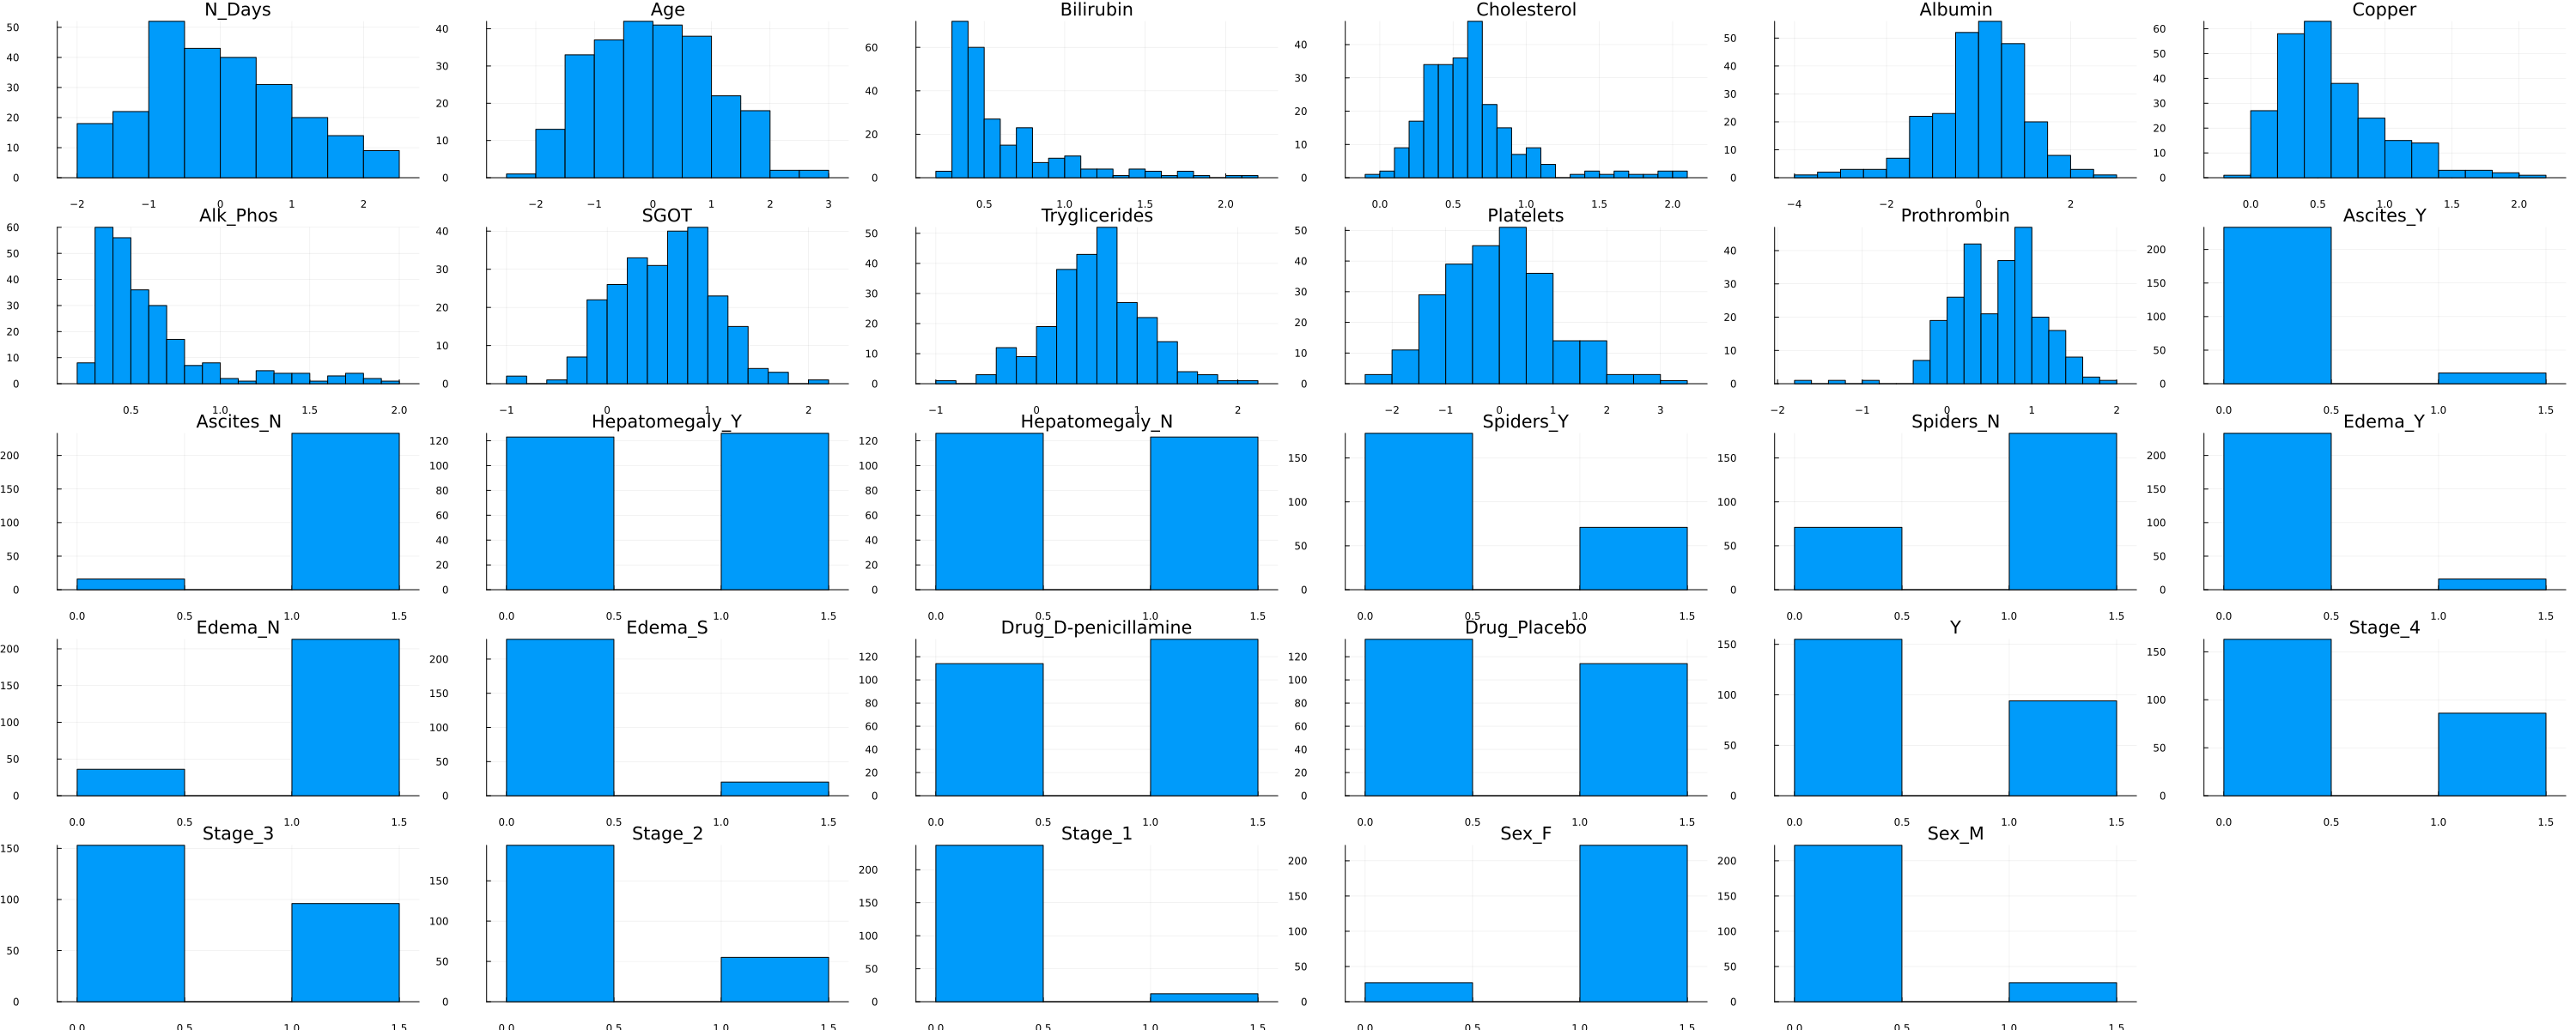

In [55]:
hists_num(trans_data)

Observe :

- We have our transformed data, as expected, which means we can now prepare the data for ML models

<a class= 'anchor' id='section5'></a>
# 5. Transform Data for ML

Let's transform the training and test data according to our pipelines

In [56]:
train_ml = prep_data(train, cont_feats, skew_feats, 2.0)

test_ml = prep_data(test, cont_feats, skew_feats, 2.0)

63×29 DataFrame
 Row │ N_Days     Age         Bilirubin  Cholesterol  Albumin      Copper      ⋯
     │ Float64    Float64     Float64    Float64      Float64      Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1.99945    0.66066     0.330274    1.26312    -0.241031     0.532079   ⋯
   2 │ -0.78322    1.13369     0.353734    0.862305    1.21811      0.675113
   3 │ -0.333488  -0.174663    0.342073    0.596143    0.00628094   0.616299
   4 │ -0.511212   0.826625    0.734734    0.759627    0.0310122    0.886037
   5 │ -0.866658   1.62234     0.941501    0.996666   -1.70017      0.880884   ⋯
   6 │ -0.327647   1.97595     0.452985    0.207977    0.0804746    0.274612
   7 │  2.11209    0.456238    0.353734    0.530356    1.58908      0.302633
   8 │  0.752043   0.30791     0.330274    0.978542   -1.15609      0.329891
   9 │  1.19009    0.0739966   0.571638    0.363246    1.98478      1.18576    ⋯
  10 │ -0.599656   0.901223    0.342073    0.753919   -0.612        0.706352
  11 │ -0.160771  -1.87422     0.330274    1.21738    -0.364687     0.502352
  ⋮  │     ⋮          ⋮           ⋮           ⋮            ⋮           ⋮       ⋱
  54 │  0.348202  -0.167434    0.803593    1.28018     0.500905     0.974517
  55 │  1.45042   -0.592469    0.318334    0.575832    1.83639     -0.171607   ⋯
  56 │ -0.975962   1.6313      0.643577    0.872524    1.21811      1.06013
  57 │  1.80086   -0.744845    0.30625     0.515937    1.49015      0.164576
  58 │  0.172982  -0.513534    0.365261    0.241975    1.19338     -0.201653
  59 │ -0.613006   0.688706    0.832738    0.756777   -0.0926439    0.960303   ⋯
  60 │  0.27728   -0.238273    0.376657    0.103941   -0.389419     0.399142
  61 │ -0.45197   -2.24548     0.888598    1.7978     -0.587268     1.32425
  62 │  0.539276  -1.92858     0.365261    0.746769    0.970799     0.338814
  63 │  0.909742   0.205844    0.353734    0.48646     1.46542      0.143201   ⋯
                                                  23 columns and 42 rows omitted

Now, we can separate the targets from the features. We are only interested in one target, "Y", as the rest of the columns will be features.

In [57]:
y, X = unpack(train_ml, ==(:Y), colname -> true)

([0, 0, 1, 1, 0, 0, 1, 1, 0, 0  …  0, 1, 0, 0, 1, 1, 0, 0, 0, 0], 249×28 DataFrame
 Row │ N_Days      Age         Bilirubin  Cholesterol  Albumin     Copper    A ⋯
     │ Float64     Float64     Float64    Float64      Float64     Float64   F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.0342706   0.667732    0.333051    0.302294    0.410752   0.297808  0 ⋯
   2 │  1.82958    -1.5627      0.368253    0.133764    1.32983    0.448691  0
   3 │ -0.301956    1.06255     0.402257    0.697221    0.787811   1.16492   0
   4 │ -0.907865    1.90669     0.482529    0.141228   -0.107704   1.2003    0
   5 │  1.19383     1.07294     0.703135    0.858374    0.245789   0.560178  0 ⋯
   6 │  0.386249    0.299543    0.402257    0.540557    0.387186   0.512924  0
   7 │  0.407049    0.330732    0.296565    0.468162    1.11774    0.403457  1
   8 │  1.86575    -0.45991     0.585076    0.854737    1.11774    0.845114  1
   9 │  1.10611     1.30851     0.4022

We separated "Y" as the target, and the remaining columns are features. We can do the same with the test dataset

In [58]:
yy, XX = unpack(test_ml, ==(:Y), colname -> true)

([0, 0, 0, 1, 1, 1, 0, 0, 1, 0  …  1, 0, 1, 0, 0, 0, 0, 1, 0, 0], 63×28 DataFrame
 Row │ N_Days     Age         Bilirubin  Cholesterol  Albumin      Copper      ⋯
     │ Float64    Float64     Float64    Float64      Float64      Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1.99945    0.66066     0.330274    1.26312    -0.241031     0.532079   ⋯
   2 │ -0.78322    1.13369     0.353734    0.862305    1.21811      0.675113
   3 │ -0.333488  -0.174663    0.342073    0.596143    0.00628094   0.616299
   4 │ -0.511212   0.826625    0.734734    0.759627    0.0310122    0.886037
   5 │ -0.866658   1.62234     0.941501    0.996666   -1.70017      0.880884   ⋯
   6 │ -0.327647   1.97595     0.452985    0.207977    0.0804746    0.274612
   7 │  2.11209    0.456238    0.353734    0.530356    1.58908      0.302633
   8 │  0.752043   0.30791     0.330274    0.978542   -1.15609      0.329891
   9 │  1.19009    0.0739966   0.571638    0.363246

Let's check that we have the exact same features in both the training and test data.

In [59]:
if MLJ.schema(X).names == MLJ.schema(XX).names
    println("The training and testing sets have the same features")
else
    println("The training and testing sets do not have the same features")
end

The training and testing sets have the same features


In [60]:
XX = Array(XX)
yy = Array(yy)
X = Array(X)
y = Array(y)

249-element Vector{Int64}:
 0
 0
 1
 1
 0
 0
 1
 1
 0
 0
 0
 0
 0
 ⋮
 0
 1
 0
 1
 0
 0
 1
 1
 0
 0
 0
 0

<a class= 'anchor' id='section6'></a>
# 6. Bayesian Logistic Regression - from scratch

Let's try to build a simple Bayesian ML model for logistic regression. I will start from first principles, and derive the mathematics first, and then implement the code based on the mathematics.

### Logistic Regression as Maximum Likelihood

A common approach in machine learning is treating the training process as an optimization problem. Equiped with some optimization algoritmh, like stochastic gradient descent, we can minimise an appropriate loss function such that we find some weights. We then use the weights to predict new instances based on new data.

There is another approach. Instead of directly optimizing a loss function,  we can estimating a probability density function and sample from it. We can formulate the problem in Bayesian terms, by finding a hypothesis that best explains the data we have. 

Given a supervised problem, which is basically the case above (we are given labels for patients, and we are asked to predict if they will survive or not), we can think in terms of conditional probabilities. What we want to do is to obtain the probability of getting the output (our response), given that we observe the input (our data). Simply put, we must estimate the weights based on oour training data:

$$
p(\mathbf{w}| \mathbf{y, X}) \tag{1}
$$

Equation $(1)$ is the probability of the weights $\bf w$, given the data $\bf y, X$. In a non-Bayesian treatment, we would simply do Maximum Likelihood Estimation, which is maximising $ p({\bf y | w} )$. 


Where does Bayes' rule come in, more exactly?

### Aim of Bayesian ML

Put simply, we want to find the probabilities of the labels, given the test data. This is our expression $(1)$, our posterior. We can use Bayes's rule to obtain the analytical expression of this, based on the likelihood:

$$ 
p(\mathbf{w}| \mathbf{y, X} ) = \frac{p( \mathbf{y} |\mathbf{w})  p(\mathbf{w})}{p(\mathbf{y})} \tag{2}
$$

In the above, $p(\mathbf{y})$ is a constant, and it represents the probability of observing the data, known as *the evidence term*. Since the evidence is a constant (not always tractable), we need expressions for the prior distribution $ p(\mathbf{w}) $, which is our belief on the distributions of the weights,  and the likelihood function that models how probable are the labels given the data $p( \mathbf{y} |\mathbf{w})$. The likelihood is modeled analytically for the problem at hand. If this would be a regression problem, the likelihood could be a Gaussian distribution. But in our case, this should be a Bernouli distribution, which is natural for binary logistic regression. 

Essentially, by calculating the posterior $ p(\mathbf{w}| y^{(i)}, x^{(i)} )$ we are **estimating** the weights from the training data, which is basically what machine learning does! In *classical* ML, we use an optimization algoritmh to calculate the weights based on the training data, but in Bayesian ML, we are using Bayes' theorem and probability to achieve the same end. In practice, it is easier to if we take the logarithm, because that transforms the product into a sum :

$$ 
\ln p(\mathbf{w}| \mathbf{y, X} ) = \ln p(\mathbf{y} |\mathbf{w}) +  \ln p(\mathbf{w}) + C \tag{3}
$$




### The Likelihood


Before we define the likelihood for all our observations $\bf y$,let us define the likelihood for for only one observation $y^{(i)}$: 

$$
p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)}) = (\sigma^{(i)})^{y^{(i)}}(1-\sigma^{(i)})^{1-y^{(i)}} \tag{4}
$$

where $\sigma^{(i)}(\mathbf{x}, \mathbf{w}) = \frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}}}$ is the logistic regression's output. 

This has an interesting interpretation. The function above returns a large probability when the model is close to the correct predicted value, and a small value if the contrary is true. 

The logistic regression output is a probability that we interpret as one class, so if the value of  $\sigma^{(i)}$ is more towards one (so the model outputs class 1, based on some predefined threshold) and the actual prediction is $y^{(i)} = 1$ (if the prediciton is correct), the first term as well as the second term will be boosted, outputing a high probability. If the prediction is wrong, that is, $y^{(i)} = 0$, the probability goes to 0. In brief:

- The probability function penalises wrong predictions
- It "rewards" good predictions

#### Joint log-likelihood: 

So now that we have gone through the justification, let us calculate the joint log-likelihood. An important things to remember is that our observations are independent! If I toss a coin, look at it, and discard it, this doesn't influence the outcome of me tossing the coin again. 

The joint log-likelihood is the logarithm of the joint likelihood. Now, since $y^{(i)}$ are conditionally independent given $\textbf{w}$, the joint likelihood is the product of the individual likelihoods :

$$ 
p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)}) \tag{5}
$$

Notice that in equation $(5)$ written above, $\mathbf{y} = \{y^{(i)}\}$, is just the vector of observations.

<p>

Taking the log transforms the product into a sum, so the joint log-likelihood becomes:

</p>

$$
\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^{n} \ln p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)}) \tag{6}
$$

<p>

Since the likelihood for probabilistic regression is given, we can write everything in terms of $\sigma^{(i)}(\mathbf{x}, \mathbf{w})$ :

</p>

$$
\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^{n} \ln [(\sigma^{(i)})^{y^{(i)}}(1-\sigma^{(i)})^{1-y^{(i)}}] \tag{7}
 $$

<p>

In the above, I simply substituted the right hand side term of the likelihood for the probabilisitic logistic regression, under the logaritm. Now, we can apply the logarithm to obtain the summand for the joint log-likelihood.

$$
\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^{n} ( y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)}) ) \tag{8}
$$


</p>

<p>

It is interesting to observe, that for binary classification (which is the case here, as the labels are either 0 or 1), $y^{(i)}$ can either be $0$ or $1$. There is no relationship between the value of the index $i$ and the corresponding value of $y^{i}$, and the sigmoid function can differ based on the current $x^{(i)}$ observation. However, the fact that the labels are binary can lead to writing the sum as (i) the sum over all 0 labels, that is, when $y^{(i)} = 0$ and the sum over all 1 labels, that is, when $y^{(i)} = 1$. 

</p>

$$ \ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \sum_{i_1: y^{(i_1)}=1} \ln \sigma^{(i_1)} + \sum_{i_0: y^{(i_0)}=0} \ln (1 - \sigma^{(i_0)}) $$
<p>

The first sum on the right hand side, represents the sum of terms calculated for all observations that belong to class 1 (all indices for which $y^{(i)} = 1$ ), and the second sum the sum of all observations that belong to class 0 (all indices for which $y^{(i)} = 0$)

<p>

An interesting observation could be that the expression above is the negative of the cross-entropy loss function.

In [61]:
function log_like(w, X = X, y = y)
    """ 
    Function that calculates the log-likelihood of the data given the weights and the features and response
    w : weights
    X : features
    y : response
    """ 
    # Small constant to avoid log0
    eps = 1e-5

    # number of observations
    n = length(y)

    # calculate the sigmoid
    sigma = sigmoid.(X * w)

    # compute logarithms
    log_1 = log.(sigma .+ eps)
    log_2 = log.((1 .- sigma) .+ eps)
    
    # calculate the log-likelihood
    log_like = sum(y .* log_1 .+ (1 .- y) .* log_2)

    return log_like

end


log_like (generic function with 3 methods)

### Distribution

Now, we must choose our prior. Choosing our prior means setting our belief system about what the distributions from which the weights follow. We can assume a zero mean Gaussian prior for the weight parameter $\mathbf{w}$:

$$
p(\mathbf{w}) = \mathcal{N}_m\left(\mathbf{w}; \mathbf{0}, \frac{1}{\lambda}\mathbf{I}\right)=\prod_{d=1}^m \mathcal{N}(w_d; 0, 1/\lambda) \tag{9}
$$

* where $ \mathcal{N}_m $ denotes a $m-dimensional$ Gaussian distribution and where 

* $\lambda$ is the precision parameter of the Gaussian.

Usually, the selection of the prior is a problem in itself. However, for our purposes, we use a Gaussian than has one parameter that controls its spread, so by changing $\lambda$ we change the Gaussian.

We see that we can express equation $(9)$ in analytical form. Since each Gaussian can be expressed analytically and each $w_j$ is independent :

$$
p(\mathbf{w}) = (\frac{1}{\sqrt{2 \pi (\frac{1}{\lambda})^{2}}})^{m} \exp{ \{ -\frac{\lambda^2}{2} \sum_{j=1}^{m} w_j^2 \}} \tag{10}
$$

Which means :

$$
p(\mathbf{w}) = (\frac{\lambda}{\sqrt{2 \pi }})^{m} \exp{ \{ -\frac{\lambda^2}{2} \sum_{j=1}^{m} w_j^2 \}} \tag{11}
$$

We can take the logarithm which gives :

$$ 
\ln{p(\mathbf{w})} = m \ln (\frac{\lambda}{2 \pi}) - \frac{\lambda^2}{2} \sum_{j=1}^{m} w_j^2  \tag{12}
$$


### Unnormalised log posterior distribution

Based on Bayes' rule, as seen above in equation $(3)$ the unnormalised log posterior distribution is defined as

$$\ln p(\mathbf{w}| \mathbf{y}, \mathbf{X}) = \ln p(\mathbf{w}|\lambda) + \ln p(\mathbf{y}|\mathbf{X}, \mathbf{w}) +\text{const}$$

The unnormalised log posterior can be written as the sum of the previous two results in equations $(8)$ and $(12)$. This means that it has the following expression :

$$
\ln p(\mathbf{w}|\{y^{(i)}\}, \mathbf{X}) =  m \ln (\frac{\lambda}{2 \pi}) - \frac{\lambda}{2} \mathbf{w}^T  \mathbf{w} + \sum_{i=1}^{m} y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)}) +\text{const} \tag{13} $$

The first constant depends on the features in the dataset $m$ and on $\lambda$. The second constant doesn't seem to be important as it vanishes under differentiation. Let's implement!

In [62]:
function un_log_post(w, lamb, X = X, y = y)
    """ 
    Function that calculates the unnormalized log-posterior of the data given the weights and the features and response
    w : weights
    X : features
    y : response
    """ 

    # datapoints
    n = length(y)

    # calculate first term
    term_1 = n * log(lamb / (2 * pi))

    # calculate second term
    term_2 = lamb * sum(w .^ 2) / 2

    # calculate third term
    term_3 = log_like(w, X, y)

    # calculate the unnormalized log-posterior
    un_log_post = term_1 - term_2 + term_3

end

un_log_post (generic function with 3 methods)

Now, we see that this distribution is not straightforward to maximize. This is particularly true because of the form of the logistic term (the sum). An easy way to still do this is to use Monte Carlo methods. In particular, I will implement the Metropolis algoritm:

- Draw from a proposed distrbution $q$ that aims to be an approximate distribution
- Calculate the acceptance ratio with the unnormalized log-posterior, and based on this, accept or reject candidates

### Metropolis Sampling

MC sampling is  making probabilistic guesses based on the data

$$
\mathbf{w}^{(m)} \sim p(\mathbf{w}|\{y^{(i)}\},\mathbf{X}),\;\; \text{for }m = 1, \ldots, M \tag{14}
$$

We will propose an approximate distribution from which we sample. Let us fix this distribution to be Gaussian and add some regularisation in the form of a $\lambda$ parameter. Let's use the following proposal distribution: 

$$
q(\mathbf{w}'|\mathbf{w}) = \mathcal{N}\left (\mathbf{w}, \left(\lambda \mathbf{I} + \frac{6}{\pi^2} \mathbf X^\top \mathbf X\right)^{-1}\right) \tag{15}
$$

The analytical expression of the distribution written above is :

$$
q(\mathbf{w}' | \mathbf{w}) = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}} \exp\left(-\frac{1}{2}(\mathbf{w}' - \mathbf{w})^T \Sigma^{-1} (\mathbf{w}' - \mathbf{w})\right) \tag{16}
$$

In the above $\Sigma$ represents the variance and its analytical form can be taken from the equation above: 

$$
\Sigma = (\lambda \mathbf{I} + \frac{6}{\pi^2} \mathbf X^\top \mathbf X)^{-1} \tag{17}
$$

For the proposal to be symmetric, the following condition must hold :

$$
q(\mathbf{w}' | \mathbf{w}) = q(\mathbf{w} | \mathbf{w}') \tag{18}
$$

Writing the analytical form of the right hand side, means swapping $\mathbf{w}$ with $\mathbf{w'}$ in the analytical expression :

$$
q(\mathbf{w} | \mathbf{w}') = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}} \exp\left(-\frac{1}{2}(\mathbf{w} - \mathbf{w}')^T \Sigma^{-1} (\mathbf{w}' - \mathbf{w}')\right) \tag{19}
$$

Forcing a $(-1)$ factor out of each term $\mathbf{w}' - \mathbf{w}'$ term, results in a plus term, leaving the result unchanged, which means : 


$$
q(\mathbf{w} | \mathbf{w}') = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}} \exp\left(-\frac{1}{2}(\mathbf{w}' - \mathbf{w})^T \Sigma^{-1} (\mathbf{w}' - \mathbf{w})\right) = q(\mathbf{w}' | \mathbf{w}) \tag{19}
$$

Thus, the proposal is symmetric. 




We need to implement two things:

- The covariance matrix
- The metropolis step to sample from the proposal

In [63]:
function covariance(lamb, X = X)
    """ 
    Function that calculates the covariance matrix of the data given the features and the regularization parameter
    X : features
    lamb : regularization parameter
    eps : small constant to avoid singularity
    """ 

    # add small constant
    eps = 1e-5

    # number of features
    m = size(X, 2)

    # identity matrix
    identity = I(m)

    #matrix to be inverted
    A = (6.0 / (pi^2)) * X' * X + lamb * identity + eps * identity

    # calculate the covariance matrix
    cov = inv(A)

    # use symmetric property to account for numerical errors
    cov = Symmetric(cov)
    

    return cov

end

covariance (generic function with 2 methods)

Let's test that this function returns a result

In [64]:
test_cov = covariance(1.0 / 100)

28×28 Symmetric{Float64, Matrix{Float64}}:
  0.0112489     0.000146438   0.00997545   …  -0.000128809  -0.000395818
  0.000146438   0.00888632    0.000895349      0.000913188  -0.00302532
  0.00997545    0.000895349   0.167369        -0.0158457     0.00472973
  0.00151811    0.00160154   -0.0493465        0.00112936   -0.00547978
 -0.00255784    0.00180853    2.64522e-5       0.00118685   -0.00179391
  0.00362299    0.000144044  -0.0359028    …   0.00879331   -0.0169867
 -0.00901775    0.0023913     0.00730092      -0.00545651   -0.00184577
 -0.000549736   0.00315761   -0.0329077        0.00282871   -0.000984441
 -0.000439736  -0.00180745   -0.0170252        0.00060339   -0.00355349
  1.67574e-5    0.000138947   0.000498621     -0.000184101   0.00244259
 -0.00296065   -0.00136055   -0.0199868    …   0.00157472   -0.00882135
 -0.000158169  -0.0041485    -0.0212219       -8.09294      -8.08533
 -0.000366457   0.00203638    0.010106        -8.10685      -8.09835
  ⋮                       

Now we can define the metropolis step

In [65]:
function metropolis(w_current, lamb, X = X, y = y)

    # Get covariance matrix
    cov = covariance(lamb, X)

    # draw a candidate from the proposal distribution
    w_candidate = rand(MvNormal(w_current, cov))

    # calculate the unnormalized log-posterior of the candidate
    un_log_post_candidate = un_log_post(w_candidate, lamb, X, y)

    # calculate the unnormalized log-posterior of the current
    un_log_post_current = un_log_post(w_current, lamb, X, y)

    # calculate the acceptance ratio
    acceptance_ratio = exp(un_log_post_candidate - un_log_post_current) ## the previous constant term vanishes in the ratio

    # accept or reject the candidate
    if rand() < acceptance_ratio
        
        return w_candidate
    else
        return w_current
    end

end


metropolis (generic function with 3 methods)

Now, we can implement the Metropolis algorithm for logistic linear regression. 

In [66]:
function metropolis_bayes_logreg(lamb, mc = 5000, burnin = 1000, X = X, y =y)

    # Initialize the weights randomly
    w_current = randn(size(X, 2))

    # create a matrix to  to store samples
    w_samples = Matrix{Float64}(undef, 0, size(X, 2))

    # run the metropolis algorithm
    for i in 1:mc

        # get the next sample
        w_current = metropolis(w_current, lamb, X, y)

        # vertically concatenate the sample
        w_samples = vcat(w_samples, w_current')

    end

    # Discard burnin samples
    w_samples = w_samples[burnin+1:end, :]

    return w_samples

end 

metropolis_bayes_logreg (generic function with 5 methods)

Now, all that is left is to define a method to output predictions

In [67]:
function predict_logreg(wsamples, X)
    """ 
    Function that predicts the class of the data given the weights and the features
    w : samples from MC
    X : features
    """ 

   # convert samples to an array
   wsamples = Array(wsamples)

   # number of samples
    n_samples = size(wsamples, 1)

    # dor product of the weights and the features
    dot_prods = X * wsamples'

    # calculate the sigmoid
    sigmoids = sigmoid.(dot_prods)

    # calculate the prediction probabilities
    probs = mean(sigmoids, dims = 2)

    # define decision boundary
    decision_boundary = 0.5

    # make predictions
    predictions = ifelse.(probs .> decision_boundary, 1, 0)

    return predictions

end

predict_logreg (generic function with 1 method)

Now, it is simple:

- We get the samples from MC, using our distribution
- Based on the MC samples we make predictions. Our samples, are basically our *weights* that we *guessed* according to the data.
- We test our predictions on the test set

In [68]:
# Get samples
Random.seed!(42) ## for reproducibility
wsamples = metropolis_bayes_logreg(1.0/100)

4000×28 Matrix{Float64}:
 -0.869806  0.727838   0.598597    …   -6.78495  -4.63562   -5.48276
 -0.869806  0.727838   0.598597        -6.78495  -4.63562   -5.48276
 -0.811513  0.692559   0.00267936      -5.8458    2.02622    1.34681
 -0.811513  0.692559   0.00267936      -5.8458    2.02622    1.34681
 -0.857597  0.700488  -0.343732        -7.88771   6.32324    5.49416
 -0.814843  0.842183  -0.0431543   …   -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543   …   -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
  ⋮                                ⋱    ⋮                   
 -1.11195

In [69]:
# length of the samples
length(wsamples)

112000

In [70]:
size(wsamples)

(4000, 28)

Note:

- As expected, we obtained 4000 MC samples : 5000 samples minus the 1000 burnin samples
- All samples have the dimension 28, which is the same as the features

In [71]:
Array(wsamples)

4000×28 Matrix{Float64}:
 -0.869806  0.727838   0.598597    …   -6.78495  -4.63562   -5.48276
 -0.869806  0.727838   0.598597        -6.78495  -4.63562   -5.48276
 -0.811513  0.692559   0.00267936      -5.8458    2.02622    1.34681
 -0.811513  0.692559   0.00267936      -5.8458    2.02622    1.34681
 -0.857597  0.700488  -0.343732        -7.88771   6.32324    5.49416
 -0.814843  0.842183  -0.0431543   …   -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543   …   -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
 -0.814843  0.842183  -0.0431543       -3.53398  -0.103738  -0.627359
  ⋮                                ⋱    ⋮                   
 -1.11195

In [72]:
# get predictions
predictions = predict_logreg(wsamples, XX)

63×1 Matrix{Int64}:
 0
 0
 0
 1
 1
 1
 1
 0
 0
 1
 0
 1
 0
 ⋮
 1
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0

As expected, we get 63 predictions. We can test these predictions on our test set. 

In [73]:
accuracy_bayes =mean(predictions .== yy)
println(accuracy_bayes)

0.7936507936507936


Observe: 

- Clearly, the accuracy we obtained is pretty good, considering that the imbalance of classes is 60:40

<a class= 'anchor' id='section7'></a>
# 7. using GML

For comparison, let us implement Logistic Regression with the Frequentist approach, by using GML, an of-the-shelf Julia package/

Let's convert back the training data to a dataframe.

In [74]:
df_train = DataFrame(X, :auto)
df_train.Y = y

249-element Vector{Int64}:
 0
 0
 1
 1
 0
 0
 1
 1
 0
 0
 0
 0
 0
 ⋮
 0
 1
 0
 1
 0
 0
 1
 1
 0
 0
 0
 0

In [75]:
fm = @formula(Y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + 
          x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + 
          x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28)

FormulaTerm
Response:
  Y(unknown)
Predictors:
  x1(unknown)
  x2(unknown)
  x3(unknown)
  x4(unknown)
  x5(unknown)
  x6(unknown)
  x7(unknown)
  x8(unknown)
  x9(unknown)
  x10(unknown)
  x11(unknown)
  x12(unknown)
  x13(unknown)
  x14(unknown)
  x15(unknown)
  x16(unknown)
  x17(unknown)
  x18(unknown)
  x19(unknown)
  x20(unknown)
  x21(unknown)
  x22(unknown)
  x23(unknown)
  x24(unknown)
  x25(unknown)
  x26(unknown)
  x27(unknown)
  x28(unknown)

In [76]:
model = glm(fm, df_train, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       z  Pr(>|z|)    Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  -4.72559      1.06115    -4.45    <1e-05    -6.8054     -2.64577
x1           -0.734862     0.23717    -3.10    0.0019    -1.19971    -0.270018
x2            0.733765     0.215696    3.40    0.0007     0.311008    1.15652
x3            0.148195     0.899991    0.16    0.8692    -1.61576     1.91215
x4            0.470389     0.707579    0.66    0.

In [77]:
df_test = DataFrame(XX, :auto)
df_test.Y = yy

63-element Vector{Int64}:
 0
 0
 0
 1
 1
 1
 0
 0
 1
 0
 0
 1
 0
 ⋮
 1
 0
 1
 0
 1
 0
 0
 0
 0
 1
 0
 0

In [78]:
GLM.predict(model, df_test)

63-element Vector{Union{Missing, Float64}}:
 0.036643416601693186
 0.17081757883201773
 0.10393664583772184
 0.8977164426469242
 0.7352380758357068
 0.6217360514745772
 0.8390898241834053
 0.010947440972383529
 0.19743903040865743
 0.5390830729015469
 0.07544089129233192
 0.9916609502223757
 0.1560275030980864
 ⋮
 0.9863659232139428
 8.593355282842507e-8
 0.00022723224554819336
 0.26032547875272116
 0.37465051844818903
 0.02633241927216344
 0.03710032061277901
 0.472691157462646
 0.03385514386459944
 0.4786378473072098
 0.008280045072005826
 0.3926892225782726

In [79]:
prediction_class = ifelse.(GLM.predict(model, df_test) .> 0.5, 1, 0)

63-element Vector{Int64}:
 0
 0
 0
 1
 1
 1
 1
 0
 0
 1
 0
 1
 0
 ⋮
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [80]:
accuracy = mean(prediction_class .== yy)
println("Accuracy with Logistic Regression for GLM: ", accuracy)
println("\n")
println("Accuracy with Bayesian Logistic Regression: ", accuracy_bayes)

Accuracy with Logistic Regression for GLM: 0.7619047619047619


Accuracy with Bayesian Logistic Regression: 0.7936507936507936


**Conclusions**

- We have pre-processed a small dataset using packages from Julia, to prepare it for being processed by Machine Learning models
- We have seen how to implement Bayesian Logistic Regression from scratch using the Metropolis algorithm
- We have used an off-the-shelf package GLM to implement Frequentist Logistci Regression

Comparing the accuracy on both datasets, it seems that the Bayesian method clearly offers very simillar results, especially on this dataset. 